# Crimes in Chicago

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from collections import Counter
import itertools

In [104]:
from sklearn import preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

In [4]:
df = pd.read_csv('crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv')

In [18]:
df.shape

(1456714, 23)

### Data Understanding

In [82]:
file = 'crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv'
crimes = pd.read_csv(file)

In [83]:
crimes.drop(['Unnamed: 0', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Location'], inplace=True, axis=1)

In [84]:
# convert dates to pandas datetime format
crimes['Date'] = pd.to_datetime(crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
crimes.index = pd.DatetimeIndex(crimes['Date'])

In [85]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'

In [86]:
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

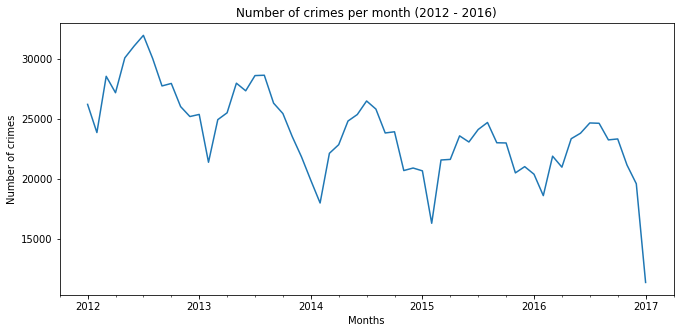

In [87]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2012 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

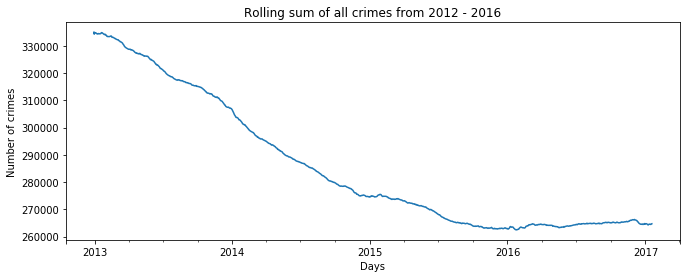

In [88]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2012 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

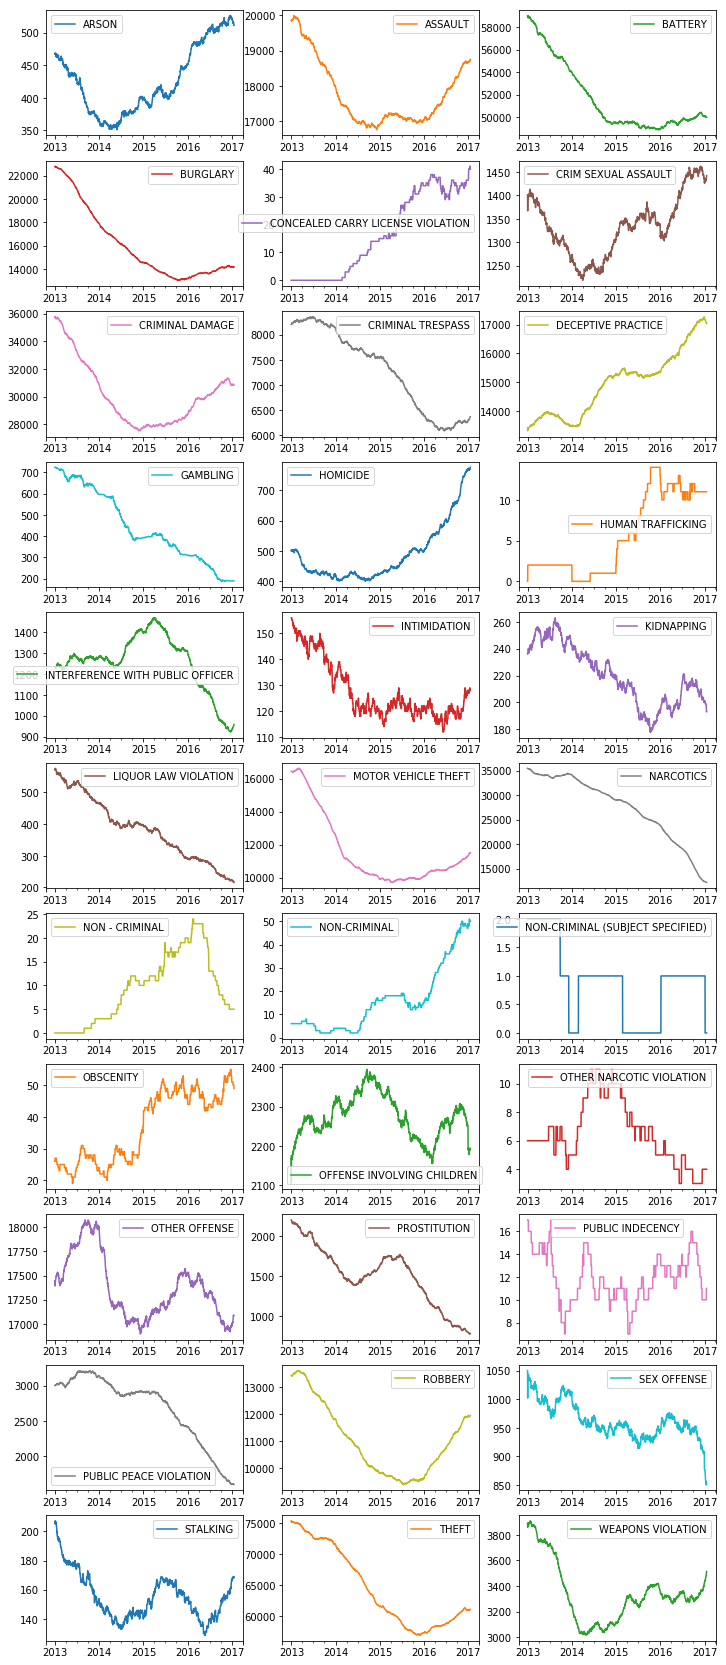

In [89]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

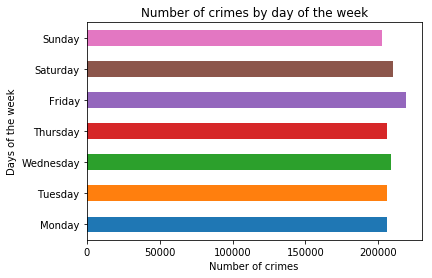

In [90]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

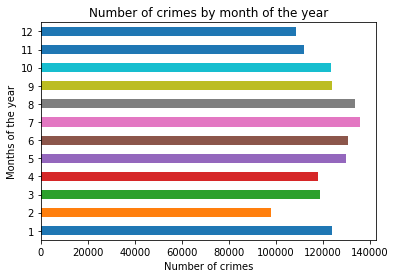

In [91]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

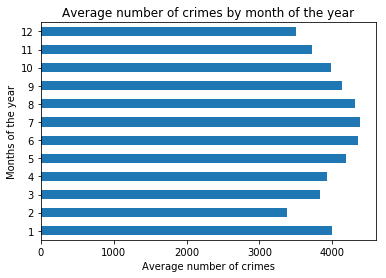

In [92]:
from calendar import monthrange
crimes_in_month = crimes.groupby([crimes.index.month]).size()
crimes_in_month.to_frame()
Avg = []
for i in range(1,13):
    Avg.append(crimes_in_month[i]/monthrange(2016, i)[1])
    
crimes_avg = pd.DataFrame(Avg, index=crimes_in_month.index)

crimes_avg.plot(kind='barh',legend = None)
plt.ylabel('Months of the year')
plt.xlabel('Average number of crimes')
plt.title('Average number of crimes by month of the year')
plt.show()

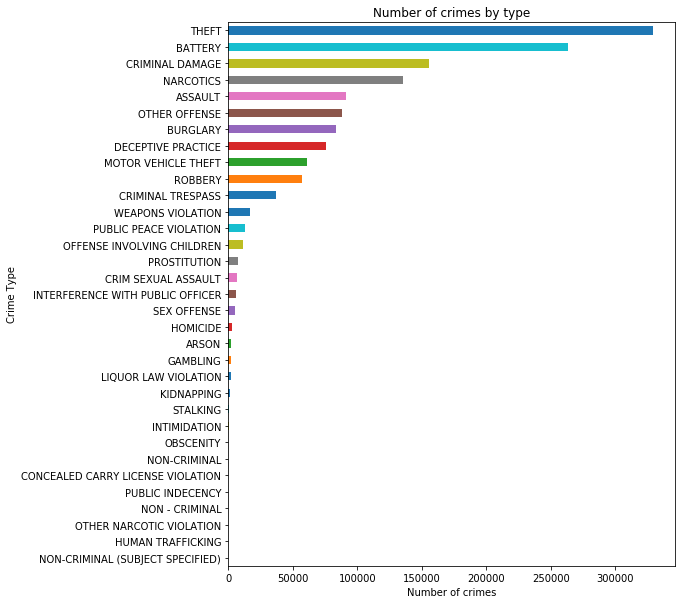

In [93]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

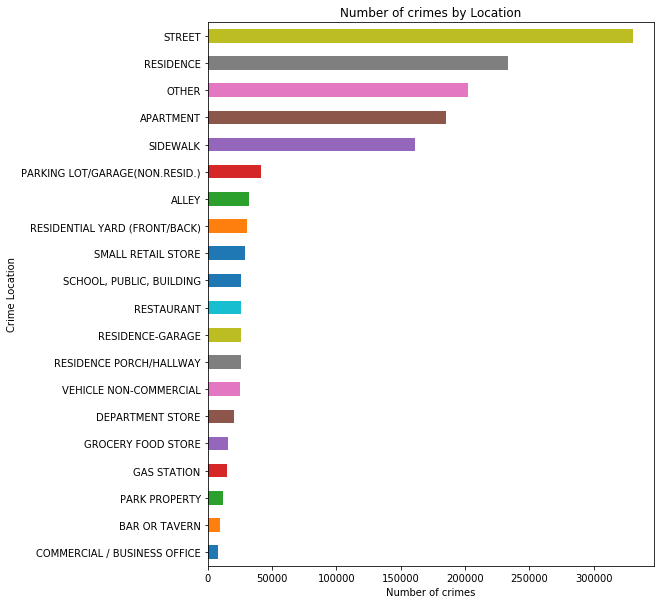

In [94]:
plt.figure(figsize=(8,10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by Location')
plt.ylabel('Crime Location')
plt.xlabel('Number of crimes')
plt.show()

In [95]:
hour_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
dayofweek_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

In [96]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()

def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)
    
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


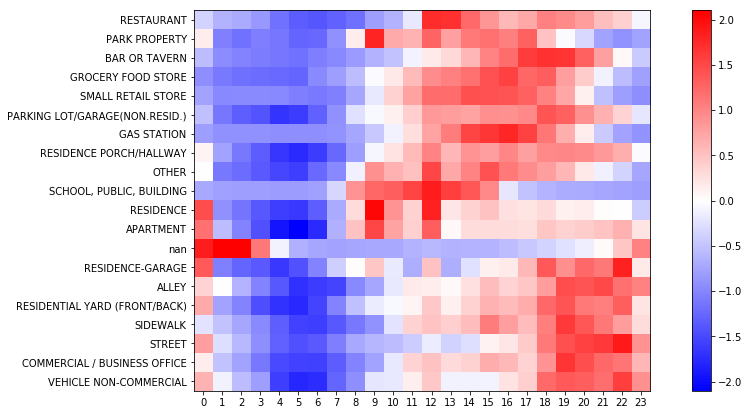

In [98]:
plt.figure(figsize=(15,7))
scale_and_plot(hour_by_location)

/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


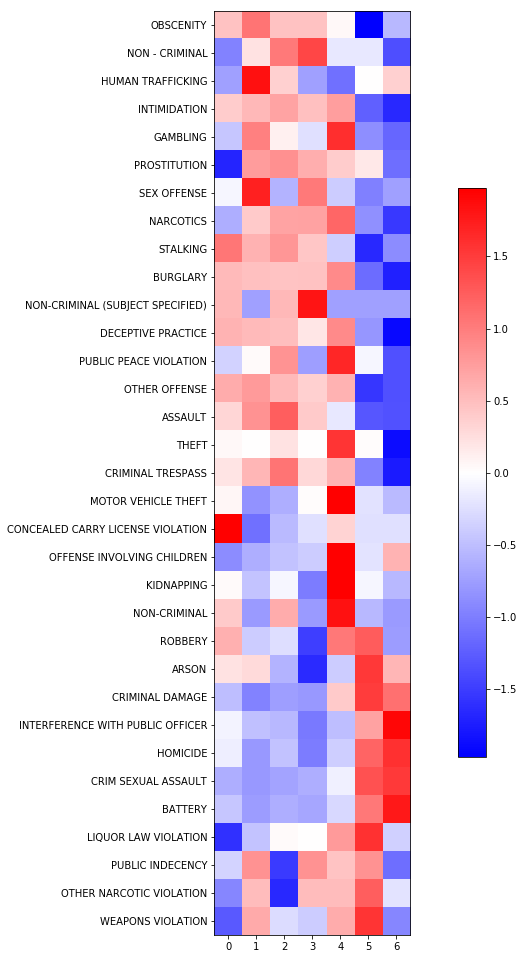

In [99]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)

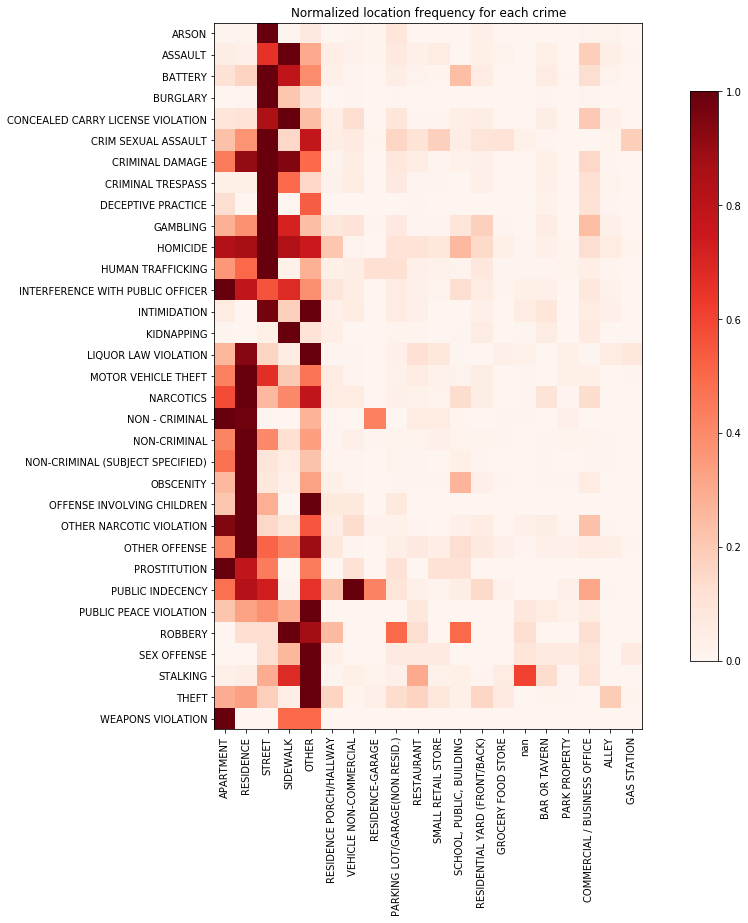

In [101]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

In [102]:
community_by_type  = crimes.pivot_table(values='ID', index='Community Area', columns='Primary Type', aggfunc=np.size).fillna(0)

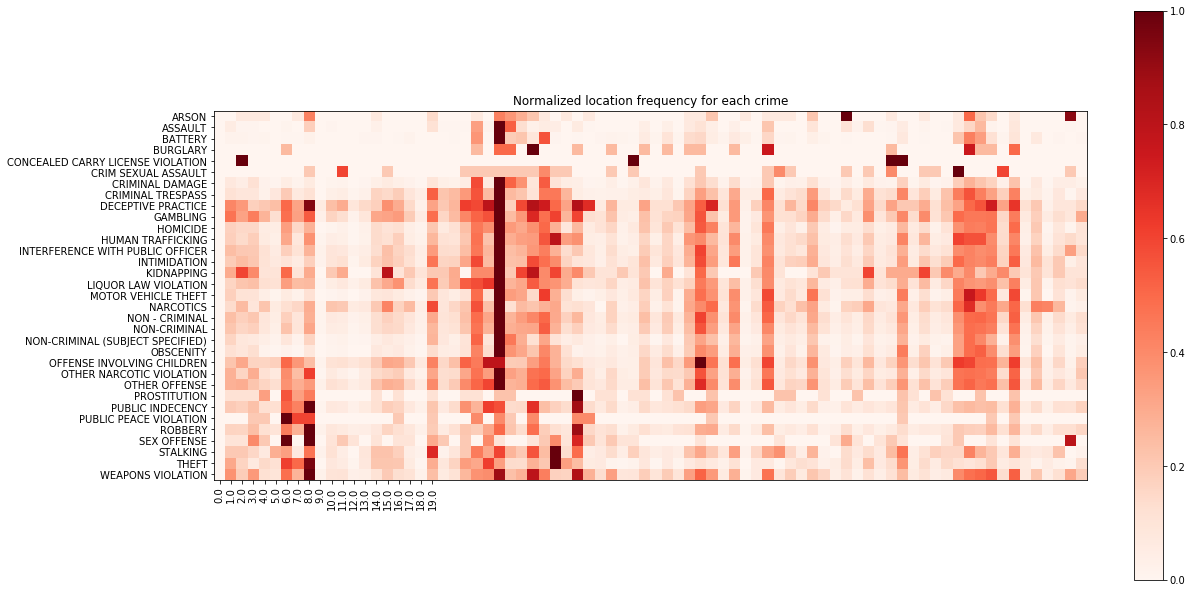

In [103]:
df_community = normalize(community_by_type)
ix = AC(3).fit(df_community.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df_community.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df_community.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df_community.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

### Feature Selection

In [19]:
dataframe = df.copy()

In [20]:
#Check the raw data structure



# nunique = dict(zip(df.columns, [df[col].nunique() for col in df.columns]))
# summary = pd.DataFrame({'number_nan':df.isna().sum(), # [df.isna().sum()][0], here [0] coerces list into series with 12 separate values
#                         'number_distinct':[df[col].nunique() for col in df.columns],
#                        'distinct vals': [df[col].unique() for col in df.columns],
#                        'data type': [type(df[col][0]) for col in df.columns]})
# summary

In [21]:
dataframe = dataframe[['Date','Primary Type','Location Description', 'Domestic','Community Area']]

In [22]:
dataframe  = dataframe.dropna()

In [23]:
dataframe.head()

Date            Primary Type Location Description  \
0  05/03/2016 11:40:00 PM                 BATTERY            APARTMENT   
1  05/03/2016 09:40:00 PM                 BATTERY            RESIDENCE   
2  05/03/2016 11:31:00 PM  PUBLIC PEACE VIOLATION               STREET   
3  05/03/2016 10:10:00 PM                 BATTERY             SIDEWALK   
4  05/03/2016 10:00:00 PM                   THEFT            RESIDENCE   

   Domestic  Community Area  
0      True            29.0  
1      True            42.0  
2     False            25.0  
3     False            25.0  
4      True            25.0

In [24]:
dataframe.Date = pd.to_datetime(dataframe.Date, format='%m/%d/%Y %I:%M:%S %p')

In [25]:
dataframe.head()

Date            Primary Type Location Description  Domestic  \
0 2016-05-03 23:40:00                 BATTERY            APARTMENT      True   
1 2016-05-03 21:40:00                 BATTERY            RESIDENCE      True   
2 2016-05-03 23:31:00  PUBLIC PEACE VIOLATION               STREET     False   
3 2016-05-03 22:10:00                 BATTERY             SIDEWALK     False   
4 2016-05-03 22:00:00                   THEFT            RESIDENCE      True   

   Community Area  
0            29.0  
1            42.0  
2            25.0  
3            25.0  
4            25.0

In [26]:
dataframe['Year']=dataframe['Date'].dt.year
dataframe['Month']=dataframe['Date'].dt.month
dataframe['Day']=dataframe['Date'].dt.day
dataframe['Time']=dataframe['Date'].dt.hour*3600+dataframe['Date'].dt.minute*60+dataframe['Date'].dt.second
dataframe['Day of Week']=dataframe['Date'].dt.dayofweek

In [27]:
# drop date
dataframe = dataframe.drop('Date',1)

In [28]:
dataframe.shape[0]/df.shape[0]
# We just drop NA values because it takes up only about 1%
# dataframe is our whole data including train and test
df_copy = dataframe.copy()

In [29]:
train, test = train_test_split(dataframe, test_size=0.2, random_state =32)
train = train.reset_index(drop=True)
test = test.reset_index(drop = True)

In [30]:
train.head()

Primary Type    Location Description  Domestic  Community Area  Year  \
0            THEFT      SMALL RETAIL STORE     False             3.0  2016   
1  CRIMINAL DAMAGE                  STREET     False            24.0  2012   
2        NARCOTICS                SIDEWALK     False            29.0  2012   
3    OTHER OFFENSE  VEHICLE NON-COMMERCIAL     False            71.0  2016   
4          BATTERY               APARTMENT      True            61.0  2014   

   Month  Day   Time  Day of Week  
0      9   30  60000            4  
1     11   26  43200            0  
2      3   11  67140            6  
3      1   14  81060            3  
4      3   29    360            5

## Feature Engineering

In [31]:
# make a dictionary of Primary Type
pt_id=dict(zip(train['Primary Type'].unique(), range(1,train['Primary Type'].nunique()+1)))

def id_pt(pt):
    if pt in pt_id:
        return pt_id[pt]
    else:
         return 0

# make a dictionary of Location Description according to the count of each location in a descending order.
# Pick N top location descriptions that crimes happen
def loc_des(N, df=train):
    loc_des_count = dict(Counter(df['Location Description']).most_common(N))
    loc_des_id = dict()
    for i, key in enumerate(loc_des_count.keys()):
        loc_des_id[key] = i+1
    value_dropped = set(dict(Counter(df['Location Description'])))-set(loc_des_count)
    return loc_des_id, value_dropped

# We pick 25 here
loc_des_id, value_dropped = loc_des(25, train)

def id_loc_des(des):
    if des in loc_des_id:
        return loc_des_id[des]
    else:
         return 0
        

## Let key and value reverse
name = dict()
for key, value in loc_des_id.items():
    name[value]=key

### Change the name of column for N columns. Will use below
def change_name(N):
    gname=dict()
    for i in range(1,N+1):
        gname['Location_Description_{}'.format(i)] = 'Location_Description_{}'.format(name[i])
    return gname

gname = change_name(25)

In [78]:
pt_id

{'THEFT': 1,
 'CRIMINAL DAMAGE': 2,
 'NARCOTICS': 3,
 'OTHER OFFENSE': 4,
 'BATTERY': 5,
 'ASSAULT': 6,
 'MOTOR VEHICLE THEFT': 7,
 'SEX OFFENSE': 8,
 'WEAPONS VIOLATION': 9,
 'BURGLARY': 10,
 'CRIMINAL TRESPASS': 11,
 'DECEPTIVE PRACTICE': 12,
 'PROSTITUTION': 13,
 'ROBBERY': 14,
 'GAMBLING': 15,
 'PUBLIC PEACE VIOLATION': 16,
 'OFFENSE INVOLVING CHILDREN': 17,
 'HOMICIDE': 18,
 'INTIMIDATION': 19,
 'ARSON': 20,
 'CRIM SEXUAL ASSAULT': 21,
 'INTERFERENCE WITH PUBLIC OFFICER': 22,
 'CONCEALED CARRY LICENSE VIOLATION': 23,
 'LIQUOR LAW VIOLATION': 24,
 'OTHER NARCOTIC VIOLATION': 25,
 'STALKING': 26,
 'KIDNAPPING': 27,
 'OBSCENITY': 28,
 'NON - CRIMINAL': 29,
 'HUMAN TRAFFICKING': 30,
 'NON-CRIMINAL': 31,
 'PUBLIC INDECENCY': 32,
 'NON-CRIMINAL (SUBJECT SPECIFIED)': 33}

In [32]:
def transform(df):
    '''
    Input the dataframe after feature selection
    Output the transformed dataframe for modeling
    '''
    
    df_new = df.copy()
    
    # Target Variable
    ## Change the Primary Type from str to int
    df_new['Primary Type'] = df_new['Primary Type'].apply(id_pt)
        
        
    # Features
    ## Change the Location Description from str to int. Drop the initial Location Description
    df_new['Location Description'] = df_new['Location Description'].apply(id_loc_des)
    loc = pd.get_dummies(df_new['Location Description'], drop_first=True, prefix = 'Location_Description')
    loc = loc.rename(columns = gname)
    df_new = pd.merge(df_new, loc, left_index=True, right_index = True)
    df_new = df_new.drop('Location Description',1)
    
    
    # Change binary variable Domestic into one column 
    domestic = pd.get_dummies(df_new['Domestic'], drop_first=True, prefix = 'Domestic')
    df_new = pd.merge(df_new, domestic, left_index=True, right_index = True)
    df_new = df_new.drop('Domestic',1)
    
    return df_new

In [33]:
train_df= transform(train)

In [34]:
test_df = transform(test)

In [35]:
#check if columns of train set and test set are the same
train_df.columns==test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [36]:
train_df.head()

Primary Type  Community Area  Year  Month  Day   Time  Day of Week  \
0             1             3.0  2016      9   30  60000            4   
1             2            24.0  2012     11   26  43200            0   
2             3            29.0  2012      3   11  67140            6   
3             4            71.0  2016      1   14  81060            3   
4             5            61.0  2014      3   29    360            5   

   Location_Description_STREET  Location_Description_RESIDENCE  \
0                            0                               0   
1                            1                               0   
2                            0                               0   
3                            0                               0   
4                            0                               0   

   Location_Description_APARTMENT      ...        \
0                               0      ...         
1                               0      ...         
2                               0      ...         
3                               0      ...         
4                               1      ...         

   Location_Description_GAS STATION  Location_Description_PARK PROPERTY  \
0                                 0                                   0   
1                                 0                                   0   
2                                 0                                   0   
3                                 0                                   0   
4                                 0                                   0   

   Location_Description_BAR OR TAVERN  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   Location_Description_COMMERCIAL / BUSINESS OFFICE  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   Location_Description_CTA PLATFORM  Location_Description_CTA TRAIN  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   Location_Description_CONVENIENCE STORE  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   Location_Description_VACANT LOT/LAND  Location_Description_HOTEL/MOTEL  \
0                                     0                                 0   
1                                     0                                 0   
2                                     0                                 0   
3                                     0                                 0   
4                                     0                                 0   

   Domestic_True  
0              0  
1              0  
2              0  
3              0  
4              1  

[5 rows x 33 columns]

In [123]:
train_df.describe()

Primary Type  Community Area          Year         Month           Day  \
count  1.164012e+06    1.164012e+06  1.164012e+06  1.164012e+06  1.164012e+06   
mean   5.395590e+00    3.746792e+01  2.013897e+03  6.511531e+00  1.561324e+01   
std    4.529118e+00    2.143972e+01  1.449352e+00  3.357503e+00  8.837499e+00   
min    1.000000e+00    0.000000e+00  2.012000e+03  1.000000e+00  1.000000e+00   
25%    2.000000e+00    2.300000e+01  2.013000e+03  4.000000e+00  8.000000e+00   
50%    5.000000e+00    3.200000e+01  2.014000e+03  7.000000e+00  1.600000e+01   
75%    7.000000e+00    5.700000e+01  2.015000e+03  9.000000e+00  2.300000e+01   
max    3.300000e+01    7.700000e+01  2.017000e+03  1.200000e+01  3.100000e+01   

               Time   Day of Week  Location_Description_STREET  \
count  1.164012e+06  1.164012e+06                 1.164012e+06   
mean   4.867332e+04  3.003987e+00                 2.267588e-01   
std    2.383418e+04  1.988833e+00                 4.187355e-01   
min    0.000000e+00  0.000000e+00                 0.000000e+00   
25%    3.240000e+04  1.000000e+00                 0.000000e+00   
50%    5.160000e+04  3.000000e+00                 0.000000e+00   
75%    6.840000e+04  5.000000e+00                 0.000000e+00   
max    8.634000e+04  6.000000e+00                 1.000000e+00   

       Location_Description_RESIDENCE  Location_Description_APARTMENT  \
count                    1.164012e+06                    1.164012e+06   
mean                     1.607020e-01                    1.270898e-01   
std                      3.672560e-01                    3.330736e-01   
min                      0.000000e+00                    0.000000e+00   
25%                      0.000000e+00                    0.000000e+00   
50%                      0.000000e+00                    0.000000e+00   
75%                      0.000000e+00                    0.000000e+00   
max                      1.000000e+00                    1.000000e+00   

           ...        Location_Description_GAS STATION  \
count      ...                            1.164012e+06   
mean       ...                            1.055659e-02   
std        ...                            1.022016e-01   
min        ...                            0.000000e+00   
25%        ...                            0.000000e+00   
50%        ...                            0.000000e+00   
75%        ...                            0.000000e+00   
max        ...                            1.000000e+00   

       Location_Description_PARK PROPERTY  Location_Description_BAR OR TAVERN  \
count                        1.164012e+06                        1.164012e+06   
mean                         8.465548e-03                        6.847868e-03   
std                          9.161818e-02                        8.246806e-02   
min                          0.000000e+00                        0.000000e+00   
25%                          0.000000e+00                        0.000000e+00   
50%                          0.000000e+00                        0.000000e+00   
75%                          0.000000e+00                        0.000000e+00   
max                          1.000000e+00                        1.000000e+00   

       Location_Description_COMMERCIAL / BUSINESS OFFICE  \
count                                       1.164012e+06   
mean                                        5.287746e-03   
std                                         7.252441e-02   
min                                         0.000000e+00   
25%                                         0.000000e+00   
50%                                         0.000000e+00   
75%                                         0.000000e+00   
max                                         1.000000e+00   

       Location_Description_CTA PLATFORM  Location_Description_CTA TRAIN  \
count                       1.164012e+06                    1.164012e+06   
mean                        4.941530e-03                    4.925207e-03   
st

In [124]:
nunique = dict(zip(train_df.columns, [train_df[col].nunique() for col in train_df.columns]))
summary = pd.DataFrame({'number_nan':train_df.isna().sum(), # [train_df.isna().sum()][0], here [0] coerces list into series with 12 separate values
                        'number_distinct':[train_df[col].nunique() for col in train_df.columns],
                       'distinct vals': [train_df[col].unique() for col in train_df.columns],
                       'data type': [type(train_df[col][0]) for col in train_df.columns]})
summary

number_nan  \
Primary Type                                                 0   
Community Area                                               0   
Year                                                         0   
Month                                                        0   
Day                                                          0   
Time                                                         0   
Day of Week                                                  0   
Location_Description_STREET                                  0   
Location_Description_RESIDENCE                               0   
Location_Description_APARTMENT                               0   
Location_Description_SIDEWALK                                0   
Location_Description_OTHER                                   0   
Location_Description_PARKING LOT/GARAGE(NON.RES...           0   
Location_Description_ALLEY                                   0   
Location_Description_RESIDENTIAL YARD (FRONT/BACK)           0   
Location_Description_SMALL RETAIL STORE                      0   
Location_Description_SCHOOL, PUBLIC, BUILDING                0   
Location_Description_RESTAURANT                              0   
Location_Description_RESIDENCE-GARAGE                        0   
Location_Description_RESIDENCE PORCH/HALLWAY                 0   
Location_Description_VEHICLE NON-COMMERCIAL                  0   
Location_Description_DEPARTMENT STORE                        0   
Location_Description_GROCERY FOOD STORE                      0   
Location_Description_GAS STATION                             0   
Location_Description_PARK PROPERTY                           0   
Location_Description_BAR OR TAVERN                           0   
Location_Description_COMMERCIAL / BUSINESS OFFICE            0   
Location_Description_CTA PLATFORM                            0   
Location_Description_CTA TRAIN                               0   
Location_Description_CONVENIENCE STORE                       0   
Location_Description_VACANT LOT/LAND                         0   
Location_Description_HOTEL/MOTEL                             0   
Domestic_True                                                0   

                                                    number_distinct  \
Primary Type                                                     33   
Community Area                                                   78   
Year                                                              6   
Month                                                            12   
Day                                                              31   
Time                                                           3943   
Day of Week                                                       7   
Location_Description_STREET                                       2   
Location_Description_RESIDENCE                                    2   
Location_Description_APARTMENT                                    2   
Location_Description_SIDEWALK                                     2   
Location_Description_OTHER                                        2   
Location_Description_PARKING LOT/GARAGE(NON.RES...                2   
Location_Description_ALLEY                                        2   
Location_Description_RESIDENTIAL YARD (FRONT/BACK)                2   
Location_Description_SMALL RETAIL STORE                           2   
Location_Description_SCHOOL, PUBLIC, BUILDING                     2   
Location_Description_RESTAURANT                                   2   
Location_Description_RESIDENCE-GARAGE                             2   
Location_Description_RESIDENCE PORCH/HALLWAY                      2   
Location_Description_VEHICLE NON-COMMERCIAL                       2   
Location_Description_DEPARTMENT STORE                             2   
Location_Description_GROCERY FOOD STORE                           2   
Location_Description_GAS STATION                                  2   
Location_Description_PARK PROPER

### train_eval

In [75]:
def train_model(model, X_train,  y_train,  param_grid={}, splits=2):

    '''
    Modeling and evaluation function

    args:
        - model: classifier object, e.g. DecisionTreeClassifier()
        - param_grid: a dictionary with possible parameters choices
        - splits: number of k-folds splits
    ''' 
    
    # create cross-validation method
    kfolds = KFold(n_splits = splits)

    ## perform cross-validation
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, cv=kfolds,
                           scoring='f1_weighted', return_train_score=True,verbose = 5)
                            # Try different scoring functions provided in:
                            # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    # search the grid
    gsearch.fit(X_train,y_train)

    # extract best model from the grid
    best_model = gsearch.best_estimator_  
    best_score = gsearch.best_score_
    
    # print stats on model performance         
    print('----------------------')
    print(best_model)
    print('----------------------')
    print('accuracy=',best_score)
    
    return best_model, best_score, gsearch

### Prepare data

In [38]:
X_train = train_df.drop('Primary Type',1)
y_train = train_df['Primary Type']

X_test = test_df.drop('Primary Type',1)
y_test = test_df['Primary Type']

In [187]:
## Resample our train data so that we have a balanced calss size for class size less than 30000 and greater than 2000
#num_desired = {8:30000, 9:50000, 11:60000, 13:40000,14:80000, 15:30000, 15:30000, 16:50000, 17:40000, 18:30000, 20:30000,21:40000,22:40000}
#smote = SMOTE(random_state=100, ratio=num_desired)#ratio=num_desired, 
#smote_tomek = SMOTETomek(smote=smote, random_state=200)
#X_train_new, y_train_new = smote_tomek.fit_sample(X_train, y_train)
#X_train_new, y_train_new = smote.fit_sample(X_train, y_train)\
#rand_over_s = RandomOverSampler(ratio=num_desired, random_state=123)
#X_train_new, y_train_new = rand_over_s.fit_sample(X_train, y_train)

In [188]:
## Note SMOTE method returns numpy array, so we need add the column names
# X_train_new = pd.DataFrame(X_train_new, columns=X_train.columns)
# y_train_new = pd.Series(y_train_new)

W'll use `X_train_new` and `y_train_new` for modeling. Use `X_train` and `y_train` for Graphing

## Model Architecture

In [39]:
# places to store optimal models and scores
opt_models = dict()
model_lst = []
score_lst = []

# no. k-fold splits
splits=4

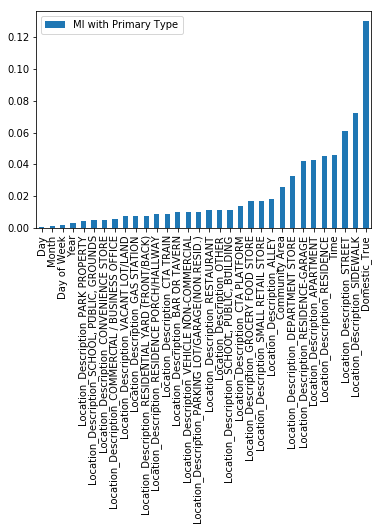

In [37]:
# Take a look of mutual information of y with all x.
ml = []
for col in X_train.columns:
    ml.append(normalized_mutual_info_score(X_train[col], y_train))
df_ml = pd.DataFrame(ml, index =X_train.columns,columns = ['MI with Primary Type'])
df_ml.sort_values(by= ['MI with Primary Type']).plot.bar()

#### Baseline Model (Logistic Regression)

In [40]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
# No need for parameter tuning
model = 'Logistc Regression'
opt_models[model] = LogisticRegression(penalty='l1',solver='saga',multi_class = 'multinomial', verbose=2, n_jobs=-1)

C = [0.5,1]
param_grid = {'C':C}
opt_models[model], cv_score_lr, grid_lr = train_model(opt_models[model], X_train, y_train, param_grid)
score_lst.append(cv_score_lr)
model_lst.append(opt_models[model])

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] C=0.5 ...........................................................
max_iter reached after 749 seconds


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.5min finished


[CV] ................. C=0.5, score=0.22954746171001675, total=12.5min
[CV] C=0.5 ...........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.5min remaining:    0.0s


max_iter reached after 746 seconds


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.4min finished


[CV] ................. C=0.5, score=0.22911619467840538, total=12.4min
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 25.0min remaining:    0.0s


max_iter reached after 766 seconds


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.8min finished


[CV] ................... C=1, score=0.22955777088208712, total=12.8min
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 37.7min remaining:    0.0s


max_iter reached after 759 seconds


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 12.7min finished


[CV] ................... C=1, score=0.22911791287375044, total=12.7min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 50.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 50.4min finished


max_iter reached after 1578 seconds
----------------------
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=2, warm_start=False)
----------------------
accuracy= 0.22933784187791878


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 26.3min finished


#### Decision Tree

In [202]:
model = 'Decision Tree'
opt_models[model] = DecisionTreeClassifier()

min_samples_split = [100,200,300,400,500,600,800,1000]
min_samples_leaf = [25,50,75,100,300,400,500]
max_features = [None,'auto','log2']
class_weight = [None, 'balanced']
param_grid = {'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 
              'max_features' : max_features, 'class_weight' : class_weight}

opt_models[model], cv_score, grid = train_model(opt_models[model], X_train, y_train, param_grid)
score_lst.append(cv_score)
model_lst.append(opt_models[model])


# ----------------------
# DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
#             max_features=None, max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=50, min_samples_split=500,
#             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#             splitter='best')
# ----------------------
# accuracy= 0.3978859324474318

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300 
[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300, score=0.3945560698686955, total=   7.2s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300, score=0.3966282134548441, total=   7.1s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300, score=0.3970818170259413, total=   7.3s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.0s remaining:    0.0s


[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=300, score=0.3973567282811518, total=   7.1s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   31.9s remaining:    0.0s


[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400, score=0.3954254767132985, total=   7.1s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400 
[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400, score=0.39763163953636216, total=   7.3s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400 
[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400, score=0.3972364546069972, total=   7.2s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400 
[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=400, score=0.3988584310127387, total=   7.1s
[CV] class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=500 
[CV]  class_weight=None, max_features=None, min_samples_leaf=25, min_samples_split=500, score=0.39585158915887464, total=   6.9s
[CV] class

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  4.8min finished


----------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
----------------------
accuracy= 0.3978859324474318


### Random Forest

In [193]:
model = 'Random Forest'
opt_models[model] = RandomForestClassifier()
min_samples_split = [100,200]
param_grid = {'min_samples_split': min_samples_split}#, 'min_samples_leaf': min_samples_leaf}

opt_models[model], cv_score, grid = train_model(opt_models[model], X_train, y_train, param_grid)

----------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------
accuracy= 0.39090490476043205


### KNN

In [105]:
model = 'KNN'
opt_models[model] = KNeighborsClassifier()
n_neighbors = [2, 4, 6, 8,10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
weights= ['distance', 'uniform']
param_grid = {'n_neighbors': n_neighbors, 'weights':weights}

opt_models[model], cv_score, grid = train_model(opt_models[model], X_train, y_train, param_grid)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] n_neighbors=2, weights=distance .................................


KeyboardInterrupt: 

### XGBoost

In [ ]:
model = 'XGBoost'
opt_models[model] = XGBClassifier(n_jobs=-1,learning_rate=0.1, gamma= 0, n_estimators=300,objective='multi:softmax', max_depth=10, silent = False)

#max_depth = [10]
#learning_rate = [0.01,0.1]
#n_estimators = [100,200,400]#,600,800,1000]
# gamma = [i/10.0 for i in range(0,5)]
# min_child_weight = range(1,6,2)
#subsample =[1]# [i/10.0 for i in range(6,10)]
colsample_bytree = [1]# good

param_grid = {'colsample_bytree': colsample_bytree}

opt_models[model], cv_score, grid = train_model(opt_models[model], X_train, y_train, param_grid)
score_lst.append(cv_score)
model_lst.append(opt_models[model])


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] colsample_bytree=1 ..............................................
[21:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 958 extra nodes, 0 pruned nodes, max_depth=10
[21:08:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[21:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[21:08:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1074 extra nodes, 0 pruned nodes, max_depth=10
[21:08:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[21:08:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=10
[21:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1000 extra nodes, 0 pruned nodes, max_depth=10
[21:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3

[21:09:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[21:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[21:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[21:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[21:10:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[21:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=10
[21:10:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[21:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 0 pruned nodes, max_depth=10
[21:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 

[21:11:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=10
[21:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[21:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=10
[21:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=10
[21:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[21:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[21:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[21:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 prun

[21:12:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 854 extra nodes, 0 pruned nodes, max_depth=10
[21:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[21:12:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[21:12:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:12:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[21:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[21:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:12:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes,

[21:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1120 extra nodes, 0 pruned nodes, max_depth=10
[21:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1262 extra nodes, 0 pruned nodes, max_depth=10
[21:13:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[21:13:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1470 extra nodes, 0 pruned nodes, max_depth=10
[21:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned no

[21:14:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 0 pruned nodes, max_depth=10
[21:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1244 extra nodes, 0 pruned nodes, max_depth=10
[21:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[21:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=10
[21:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[21:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[21:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[21:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 854 extra nodes, 0 pruned nodes, max_depth=10
[21:14:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 

[21:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 0 pruned nodes, max_depth=10
[21:15:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=10
[21:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[21:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=10
[21:16:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[21:16:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=10
[21:16:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=10
[21:16:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[21:16:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pr

[21:17:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[21:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[21:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[21:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[21:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[21:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:17:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[21:17:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned no

[21:18:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[21:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[21:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[21:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:18:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:18:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:18:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1046 extra nodes, 0 pruned nodes, max

[21:19:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 0 pruned nodes, max_depth=10
[21:19:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 0 pruned nodes, max_depth=10
[21:19:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[21:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 0 pruned nodes, max_depth=10
[21:19:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1488 extra nodes, 0 pruned nodes, max_depth=10
[21:19:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1068 extra nodes, 0 pruned nodes, max_depth=10
[21:19:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 0 pruned nodes, max_depth=10
[21:19:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 500 extra nodes, 0 pruned nodes, max_depth=10
[21:20:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 610 extra node

[21:21:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[21:21:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[21:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[21:21:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[21:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[21:21:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[21:21:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[21:21:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[21:21:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 

[21:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[21:22:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=10
[21:22:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 0 pruned nodes, max_depth=10
[21:22:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[21:22:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[21:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[21:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[21:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[21:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pru

[21:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[21:23:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=7
[21:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[21:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[21:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[21:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[21:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:23:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes

[21:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:25:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nodes, max_depth=10
[21:25:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1022 extra nodes, 0 pruned nodes, max_depth=10
[21:25:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[21:25:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[21:25:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 0 pruned nod

[21:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 0 pruned nodes, max_depth=10
[21:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[21:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned nodes, max_depth=10
[21:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1074 extra nodes, 0 pruned nodes, max_depth=10
[21:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[21:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[21:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[21:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[21:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0

[21:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=10
[21:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=10
[21:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[21:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 920 extra nodes, 0 pruned nodes, max_depth=10
[21:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[21:27:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[21:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[21:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[21:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 p

[21:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[21:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[21:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[21:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=10
[21:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[21:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=8
[21:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[21:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned

[21:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[21:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[21:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[21:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[21:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[21:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:30:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, 

[21:32:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 0 pruned nodes, max_depth=10
[21:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=10
[21:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[21:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 0 pruned nodes, max_depth=10
[21:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[21:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[21:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=10
[21:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[21:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 

[21:33:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[21:33:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[21:33:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[21:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[21:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[21:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[21:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[21:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[21:33:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 p

[21:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[21:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[21:34:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[21:34:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[21:35:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[21:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[21:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[21:35:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[21:35:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pr

[21:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[21:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[21:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[21:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:36:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[21:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[21:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[21:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes

[21:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[21:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[21:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[21:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[21:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[21:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[21:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nod

[21:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 870 extra nodes, 0 pruned nodes, max_depth=10
[21:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nodes, max_depth=10
[21:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[21:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[21:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[21:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[21:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[21:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[21:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 

[21:40:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[21:40:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[21:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[21:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[21:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[21:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[21:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[21:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[21:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 p

[21:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[21:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[21:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[21:42:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[21:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[21:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[21:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[21:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 prun

[21:43:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:43:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[21:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[21:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[21:43:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[21:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[21:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[21:43:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, m

[21:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:45:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=10
[21:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[21:45:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[21:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[21:45:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1290 extra nodes, 0 pruned nodes, max_depth=10
[21:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[21:45:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 prun

[21:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[21:46:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[21:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[21:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[21:46:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[21:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[21:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1134 extra nodes, 0 pruned nodes, max_depth=10
[21:46:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[21:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 

[21:47:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[21:47:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[21:47:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[21:47:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[21:47:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[21:47:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[21:48:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[21:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[21:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 p

[21:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[21:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[21:49:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[21:49:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[21:49:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[21:49:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[21:49:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[21:49:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[21:49:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 prun

[21:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[21:50:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[21:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[21:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[21:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[21:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1260 extra nodes, 0 pruned nodes, max_depth=10
[21:50:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nod

[21:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[21:52:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 0 pruned nodes, max_depth=10
[21:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[21:52:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[21:52:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[21:52:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[21:52:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[21:52:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[21:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 

[21:53:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[21:53:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[21:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[21:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 900 extra nodes, 0 pruned nodes, max_depth=10
[21:53:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1138 extra nodes, 0 pruned nodes, max_depth=10
[21:53:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[21:53:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[21:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[21:53:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 

[21:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[21:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[21:55:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[21:55:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[21:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[21:55:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[21:55:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[21:55:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[21:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pru

[21:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[21:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[21:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[21:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[21:56:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[21:56:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[21:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[21:56:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[21:56:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned

[21:58:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[21:58:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[21:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[21:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[21:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[21:58:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=10
[21:58:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=10
[21:58:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[21:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned no

[21:59:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[21:59:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[21:59:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[21:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[21:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[21:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[21:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[21:59:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[21:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 p

[22:01:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[22:01:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[22:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1256 extra nodes, 0 pruned nodes, max_depth=10
[22:01:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[22:01:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[22:01:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[22:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[22:01:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[22:01:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 p

[22:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[22:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[22:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[22:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[22:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[22:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[22:02:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[22:02:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[22:02:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 prun

[22:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[22:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[22:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[22:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[22:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[22:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[22:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[22:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned 

[22:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[22:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[22:05:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[22:05:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1426 extra nodes, 0 pruned nodes, max_depth=10
[22:05:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=10
[22:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1232 extra nodes, 0 pruned nodes, max_depth=10
[22:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[22:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[22:05:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pru

[22:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1390 extra nodes, 0 pruned nodes, max_depth=10
[22:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[22:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=10
[22:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[22:07:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[22:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[22:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[22:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[22:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 

[22:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 pruned nodes, max_depth=10
[22:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[22:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[22:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[22:08:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[22:08:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[22:08:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[22:08:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[22:08:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pru

[22:10:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[22:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[22:10:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[22:10:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[22:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[22:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[22:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[22:10:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[22:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 prun

[22:11:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[22:11:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[22:11:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[22:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[22:11:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[22:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[22:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[22:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:12:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1138 extra nodes, 0 pruned n

[22:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes, max_depth=10
[22:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[22:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1122 extra nodes, 0 pruned nodes, max_depth=10
[22:13:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[22:13:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 0 pruned nodes, max_depth=10
[22:13:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1352 extra nodes, 0 pruned nodes, max_depth=10
[22:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[22:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 p

[22:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[22:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[22:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[22:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[22:14:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[22:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[22:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[22:15:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[22:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pr

[22:16:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[22:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[22:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[22:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[22:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[22:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[22:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[22:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[22:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 prune

[22:17:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[22:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[22:17:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[22:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[22:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[22:18:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[22:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[22:18:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[22:18:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned

[22:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[22:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[22:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[22:19:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[22:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[22:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1322 extra nodes, 0 pruned nodes, max_depth=10
[22:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 0 pruned nodes, max_depth=10
[22:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1026 extra nodes, 0 pruned

[22:20:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=10
[22:21:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[22:21:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[22:21:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[22:21:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1158 extra nodes, 0 pruned nodes, max_depth=10
[22:21:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[22:21:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[22:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[22:21:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 

[22:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[22:22:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[22:22:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[22:22:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[22:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[22:22:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[22:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[22:22:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[22:22:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pru

[22:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[22:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[22:24:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[22:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[22:24:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[22:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[22:24:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[22:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned

[22:25:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[22:25:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[22:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[22:25:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[22:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[22:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[22:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:25:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[22:25:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned node

[22:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[22:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[22:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[22:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[22:27:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1052 extra nodes, 0 pruned nodes, max_depth=10
[22:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1182 extra nodes, 0 pruned nodes, max_depth=10
[22:27:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[22:27:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=10
[22:27:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 prune

[22:28:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[22:28:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1206 extra nodes, 0 pruned nodes, max_depth=10
[22:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[22:28:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[22:28:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[22:28:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[22:28:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[22:28:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[22:28:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 

[22:30:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[22:30:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[22:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[22:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[22:30:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[22:30:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[22:30:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[22:30:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[22:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 prune

[22:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[22:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[22:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[22:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[22:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[22:31:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[22:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[22:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[22:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned n

[22:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[22:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[22:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[22:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[22:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[22:33:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[22:33:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[22:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[22:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes

[22:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[22:34:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[22:34:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 882 extra nodes, 0 pruned nodes, max_depth=10
[22:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1132 extra nodes, 0 pruned nodes, max_depth=10
[22:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[22:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[22:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=10
[22:34:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[22:34:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pru

[22:36:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[22:36:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[22:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[22:36:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[22:36:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[22:36:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[22:36:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[22:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[22:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 p

[22:37:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[22:37:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[22:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[22:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[22:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[22:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[22:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[22:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[22:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 prun

[22:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[22:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[22:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[22:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[22:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[22:39:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[22:39:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[22:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned 

[22:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[22:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[22:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[22:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[22:40:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[22:40:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[22:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[22:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=10
[22:40:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned no

[22:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=10
[22:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 896 extra nodes, 0 pruned nodes, max_depth=10
[22:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=10
[22:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[22:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=10
[22:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[22:42:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[22:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[22:42:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 p

[22:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[22:43:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[22:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[22:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[22:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=10
[22:43:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[22:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[22:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[22:43:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 p

[22:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[22:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[22:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[22:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[22:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[22:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[22:45:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[22:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[22:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned 

[22:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[22:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[22:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[22:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[22:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[22:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[22:46:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[22:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[22:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned no

[22:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[22:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[22:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[22:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[22:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[22:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 0 pruned nodes, max_depth=10
[22:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=10
[22:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[22:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned n

[22:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 896 extra nodes, 0 pruned nodes, max_depth=10
[22:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[22:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 988 extra nodes, 0 pruned nodes, max_depth=10
[22:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[22:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[22:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[22:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[22:50:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[22:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pr

[22:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[22:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[22:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[22:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[22:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[22:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[22:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[22:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[22:51:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pru

[22:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[22:52:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[22:52:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[22:52:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[22:52:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[22:52:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[22:52:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[22:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[22:53:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned 

[22:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[22:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[22:54:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[22:54:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[22:54:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[22:54:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[22:54:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[22:54:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[22:54:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nod

[22:55:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[22:55:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=9
[22:55:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[22:55:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[22:55:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[22:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[22:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[22:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[22:56:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned 

[22:57:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=10
[22:57:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=10
[22:57:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[22:57:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[22:57:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[22:57:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[22:57:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[22:57:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 990 extra nodes, 0 pruned nodes, max_depth=10
[22:57:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pr

[22:58:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[22:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[22:58:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[22:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[22:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[22:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[22:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[22:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[22:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 prun

[23:00:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[23:00:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[23:00:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:00:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[23:00:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[23:00:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[23:00:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:00:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[23:00:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned

[23:01:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[23:01:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[23:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[23:01:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=9
[23:02:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[23:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[23:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:02:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[23:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1274 extra nodes, 0 pruned nod

[23:03:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[23:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=10
[23:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[23:03:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[23:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[23:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[23:03:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[23:03:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 prun

[23:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 646 extra nodes, 0 pruned nodes, max_depth=10
[23:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[23:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[23:05:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[23:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 0 pruned nodes, max_depth=10
[23:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[23:05:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[23:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 p

[23:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[23:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[23:06:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[23:06:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[23:06:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[23:06:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[23:06:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[23:06:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 prun

[23:08:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[23:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[23:08:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[23:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[23:08:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[23:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[23:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[23:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned n

[23:09:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[23:09:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[23:09:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:09:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[23:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[23:09:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:09:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=10
[23:09:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[23:09:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 894 extra nodes, 0 pruned nod

[23:11:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[23:11:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[23:11:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 0 pruned nodes, max_depth=10
[23:11:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1276 extra nodes, 0 pruned nodes, max_depth=10
[23:11:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=10
[23:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10
[23:11:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[23:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[23:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 

[23:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[23:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes, 0 pruned nodes, max_depth=10
[23:12:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[23:12:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1050 extra nodes, 0 pruned nodes, max_depth=10
[23:12:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[23:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[23:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:12:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[23:12:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 p

[23:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[23:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[23:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[23:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:14:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[23:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[23:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[23:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[23:14:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 prune

[23:15:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[23:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[23:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[23:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[23:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[23:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[23:15:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[23:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[23:15:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned n

[23:17:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[23:17:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[23:17:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1088 extra nodes, 0 pruned nodes, max_depth=10
[23:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1126 extra nodes, 0 pruned nodes, max_depth=10
[23:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[23:17:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[23:17:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned

[23:18:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[23:18:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[23:18:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[23:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[23:18:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[23:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[23:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[23:18:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[23:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 p

[23:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[23:20:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[23:20:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[23:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[23:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[23:20:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[23:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[23:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[23:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 p

[23:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[23:21:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[23:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[23:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[23:21:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[23:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pruned nodes, max_depth=10
[23:21:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[23:21:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned

[23:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:23:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[23:23:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[23:23:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[23:23:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[23:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[23:23:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[23:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes

[23:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[23:24:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:24:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[23:24:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 0 pruned nodes, max_depth=10
[23:24:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=10
[23:24:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[23:24:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[23:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[23:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 prune

[23:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[23:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[23:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[23:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[23:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[23:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[23:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[23:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[23:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pr

[23:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[23:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[23:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[23:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[23:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[23:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[23:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[23:27:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[23:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pru

[23:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[23:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[23:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[23:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=9
[23:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[23:29:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[23:29:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[23:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[23:29:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned 

[23:30:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[23:30:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[23:30:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[23:30:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=8
[23:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[23:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[23:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:31:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[23:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1240 extra nodes, 0 pruned no

[23:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 922 extra nodes, 0 pruned nodes, max_depth=10
[23:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=10
[23:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[23:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[23:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[23:32:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[23:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[23:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[23:32:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 p

[23:33:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[23:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[23:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 pruned nodes, max_depth=10
[23:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=10
[23:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[23:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[23:34:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[23:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[23:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 p

[23:35:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[23:35:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[23:35:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[23:35:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[23:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[23:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[23:35:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[23:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 prune

[23:36:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[23:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:37:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[23:37:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[23:37:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[23:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[23:37:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[23:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nod

[23:38:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[23:38:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:38:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[23:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[23:38:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[23:38:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=10
[23:38:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[23:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[23:38:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned no

[23:40:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[23:40:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[23:40:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 0 pruned nodes, max_depth=10
[23:40:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned nodes, max_depth=10
[23:40:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[23:40:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[23:40:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[23:40:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[23:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 

[23:41:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[23:41:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[23:41:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[23:41:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[23:41:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[23:41:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[23:41:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[23:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[23:41:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pr

[23:43:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[23:43:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[23:43:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[23:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[23:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[23:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[23:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[23:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[23:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 prune

[23:44:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[23:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[23:44:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[23:44:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[23:44:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[23:44:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:44:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[23:44:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nod

[23:46:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[23:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[23:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[23:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 916 extra nodes, 0 pruned nodes, max_depth=10
[23:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=10
[23:46:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1032 extra nodes, 0 pruned nodes, max_depth=10
[23:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[23:46:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[23:46:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 prune

[23:47:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[23:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[23:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[23:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[23:47:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[23:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[23:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[23:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[23:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pr

[23:49:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[23:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[23:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[23:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[23:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[23:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[23:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[23:49:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[23:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pr

[23:50:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[23:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[23:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[23:50:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[23:50:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[23:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[23:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[23:50:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[23:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 prun

[23:52:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[23:52:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[23:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[23:52:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[23:52:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[23:52:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[23:52:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[23:52:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned node

[23:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[23:53:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[23:53:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[23:53:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[23:53:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=10
[23:53:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[23:53:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[23:53:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10
[23:53:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pr

[23:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[23:55:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[23:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[23:55:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[23:55:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[23:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[23:55:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[23:55:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 prun

[23:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[23:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[23:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[23:56:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[23:56:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[23:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[23:56:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[23:56:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[23:56:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 p

[23:58:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[23:58:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[23:58:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=8
[23:58:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[23:58:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[23:58:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[23:58:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[23:58:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[23:58:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned n

[23:59:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[23:59:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[23:59:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[23:59:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[23:59:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[23:59:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[23:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra nodes, 0 pruned nodes, max_depth=10
[23:59:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[23:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned no

[00:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 pruned nodes, max_depth=10
[00:01:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 0 pruned nodes, max_depth=10
[00:01:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[00:01:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=10
[00:01:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[00:01:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[00:01:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[00:01:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[00:01:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 

[00:02:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[00:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[00:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[00:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[00:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[00:02:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[00:02:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[00:02:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[00:02:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 p

[00:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[00:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[00:04:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[00:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[00:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[00:04:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[00:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[00:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=8
[00:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 prun

[00:05:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[00:05:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[00:05:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[00:05:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[00:05:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[00:05:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[00:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[00:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[00:05:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned no

[00:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[00:07:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[00:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:07:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[00:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[00:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[00:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1114 extra nodes, 0 pruned nodes, max_depth=10
[00:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 550 extra nodes, 0 pruned nodes, max_depth=10
[00:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 796 extra nodes, 0 pruned n

[00:08:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[00:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[00:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 892 extra nodes, 0 pruned nodes, max_depth=10
[00:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[00:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[00:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[00:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[00:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[00:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 p

[00:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[00:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[00:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[00:10:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[00:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[00:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[00:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[00:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[00:10:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pr

[00:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[00:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[00:11:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[00:11:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[00:11:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[00:11:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[00:11:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[00:11:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[00:11:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned

[00:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[00:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[00:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[00:13:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[00:13:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[00:13:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[00:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[00:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:13:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes,

[00:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[00:14:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:14:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[00:14:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[00:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[00:14:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[00:14:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 844 extra nodes, 0 pruned nodes, max_depth=10
[00:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[00:14:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned

[00:16:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[00:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[00:16:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[00:16:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[00:16:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 0 pruned nodes, max_depth=10
[00:16:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[00:16:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[00:16:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[00:16:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 p

[00:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[00:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[00:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[00:17:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[00:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[00:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[00:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[00:17:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[00:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pr

[00:19:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[00:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[00:19:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[00:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[00:19:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[00:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=7
[00:19:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[00:19:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[00:19:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 prune

[00:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[00:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[00:20:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[00:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=7
[00:20:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[00:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 874 extra nodes, 0 pruned nodes, max_depth=10
[00:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 extra nodes, 0 pruned node

[00:22:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[00:22:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=10
[00:22:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[00:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[00:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[00:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[00:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[00:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[00:22:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 p

[00:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[00:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[00:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=10
[00:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[00:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[00:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[00:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10
[00:23:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[00:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 p

[00:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[00:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[00:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[00:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[00:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[00:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[00:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[00:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[00:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pr

[00:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[00:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[00:26:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[00:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[00:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[00:26:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[00:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[00:26:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=7
[00:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned n

[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[00:28:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=5
[00:28:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[00:28:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[00:28:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[00:28:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=10
[00:28:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra nodes, 0 pruned nodes, max_depth=10
[00:28:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[00:28:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned no

/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 281.9min remaining:    0.0s


[CV] .... colsample_bytree=1, score=0.4135644649711515, total=243.0min
[CV] colsample_bytree=1 ..............................................
[01:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=10
[01:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1216 extra nodes, 0 pruned nodes, max_depth=10
[01:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 892 extra nodes, 0 pruned nodes, max_depth=10
[01:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_depth=10
[01:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[01:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 extra nodes, 0 pruned nodes, max_depth=10
[01:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1066 extra nodes, 0 pruned nodes, max_depth=10
[01:50:54] src/tree/updater_prune.cc:74: tree pruning en

[01:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=10
[01:51:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=10
[01:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[01:51:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=10
[01:51:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pruned nodes, max_depth=10
[01:52:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[01:52:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 978 extra nodes, 0 pruned nodes, max_depth=10
[01:52:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[01:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 

[01:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[01:53:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[01:53:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[01:53:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=10
[01:53:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=10
[01:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[01:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:53:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[01:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 prun

[01:54:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[01:54:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[01:54:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10
[01:54:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[01:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:54:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[01:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[01:54:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned no

[01:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[01:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[01:55:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1092 extra nodes, 0 pruned nodes, max_depth=10
[01:55:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes, 0 pruned nodes, max

[01:56:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1190 extra nodes, 0 pruned nodes, max_depth=10
[01:56:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 0 pruned nodes, max_depth=10
[01:56:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[01:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1244 extra nodes, 0 pruned nodes, max_depth=10
[01:56:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 0 pruned nodes, max_depth=10
[01:56:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[01:56:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 pruned nodes, max_depth=10
[01:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[01:56:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes

[01:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[01:57:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[01:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[01:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[01:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned nodes, max_depth=10
[01:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[01:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra nodes, 0 pruned nodes, max_depth=10
[01:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[01:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 

[01:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[01:58:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[01:59:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=10
[01:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[01:59:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[01:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[01:59:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[01:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[01:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned

[02:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[02:00:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[02:00:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:00:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[02:00:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[02:00:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[02:00:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:00:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, 

[02:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:01:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:01:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 extra nodes, 0 pruned nodes, max_depth=10
[02:01:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=10
[02:01:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[02:01:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[02:01:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1308 extra nodes, 0 pruned nodes, max_depth=10
[02:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned 

[02:02:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 0 pruned nodes, max_depth=10
[02:02:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 0 pruned nodes, max_depth=10
[02:02:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=10
[02:02:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[02:02:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 624 extra nodes, 0 pruned nodes, max_depth=10
[02:02:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[02:02:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[02:02:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[02:02:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0

[02:03:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pruned nodes, max_depth=10
[02:03:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[02:03:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[02:03:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[02:03:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[02:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 970 extra nodes, 0 pruned nodes, max_depth=10
[02:03:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[02:03:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[02:04:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pr

[02:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[02:05:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[02:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[02:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[02:05:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[02:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:05:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 0 pruned nodes, max_depth=10
[02:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned n

[02:06:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[02:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1068 extra nodes, 0 pruned nodes, max

[02:07:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:07:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=10
[02:07:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1032 extra nodes, 0 pruned nodes, max_depth=10
[02:07:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 680 extra nodes, 0 pruned nodes, max_depth=10
[02:07:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[02:07:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 0 pruned nodes, max_depth=10
[02:07:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[02:07:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[02:07:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pru

[02:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 0 pruned nodes, max_depth=10
[02:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[02:08:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[02:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[02:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[02:08:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 848 extra nodes, 0 pruned nodes, max_depth=10
[02:08:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[02:08:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[02:08:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 

[02:09:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 784 extra nodes, 0 pruned nodes, max_depth=10
[02:10:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[02:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[02:10:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[02:10:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[02:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[02:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[02:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[02:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 p

[02:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[02:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[02:11:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[02:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[02:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[02:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nod

[02:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=7
[02:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[02:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:12:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=10
[02:12:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=10
[02:12:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, ma

[02:13:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=10
[02:13:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[02:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[02:13:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[02:13:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[02:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 0 pruned nodes, max_depth=10
[02:13:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[02:13:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[02:13:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 

[02:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[02:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[02:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[02:15:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[02:15:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=10
[02:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[02:15:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[02:15:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10
[02:15:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 p

[02:16:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 538 extra nodes, 0 pruned nodes, max_depth=10
[02:16:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=10
[02:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[02:16:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[02:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[02:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[02:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[02:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[02:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pru

[02:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:17:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=10
[02:17:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[02:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[02:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[02:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:17:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:17:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, 

[02:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[02:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:18:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:18:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 0 pruned nodes, max_depth=10
[02:19:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=10
[02:19:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[02:19:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=10
[02:19:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nod

[02:20:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[02:20:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[02:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[02:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[02:20:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[02:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[02:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[02:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[02:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 p

[02:21:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[02:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[02:21:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 556 extra nodes, 0 pruned nodes, max_depth=10
[02:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[02:21:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[02:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[02:21:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[02:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[02:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 p

[02:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[02:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[02:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[02:23:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[02:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[02:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[02:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[02:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 prun

[02:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[02:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[02:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[02:24:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[02:24:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[02:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=9
[02:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[02:24:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, m

[02:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[02:25:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 0 pruned nodes, max_depth=10
[02:25:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[02:25:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[02:25:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[02:25:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[02:25:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[02:25:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned

[02:27:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 0 pruned nodes, max_depth=10
[02:27:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=10
[02:27:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[02:27:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[02:27:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[02:27:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 0 pruned nodes, max_depth=10
[02:27:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=10
[02:27:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[02:27:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 p

[02:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[02:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 566 extra nodes, 0 pruned nodes, max_depth=10
[02:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[02:28:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[02:28:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[02:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[02:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[02:28:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[02:28:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 p

[02:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[02:29:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[02:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[02:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[02:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[02:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[02:29:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[02:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[02:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 prun

[02:31:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[02:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[02:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[02:31:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[02:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[02:31:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 902 extra nodes, 0 pruned nodes, max_depth=10
[02:31:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes

[02:32:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[02:32:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nodes, max_depth=10
[02:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[02:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[02:32:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 672 extra nodes, 0 pruned nodes, max_depth=10
[02:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[02:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[02:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[02:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 p

[02:33:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[02:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[02:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[02:34:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[02:34:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 0 pruned nodes, max_depth=10
[02:34:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[02:34:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[02:34:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[02:34:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 

[02:35:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[02:35:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[02:35:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[02:35:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[02:35:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[02:35:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[02:35:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[02:35:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[02:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pru

[02:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[02:36:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[02:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[02:36:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[02:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[02:36:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[02:36:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[02:36:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[02:36:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned n

[02:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[02:38:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[02:38:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=8
[02:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=8
[02:38:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:38:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[02:38:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1074 extra nodes, 0 pruned nodes, max_depth=10
[02:38:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[02:38:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned node

[02:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes, 0 pruned nodes, max_depth=10
[02:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[02:39:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 636 extra nodes, 0 pruned nodes, max_depth=10
[02:39:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[02:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[02:39:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[02:39:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[02:39:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[02:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 p

[02:41:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[02:41:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[02:41:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=10
[02:41:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[02:41:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[02:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[02:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[02:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[02:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 p

[02:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[02:42:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[02:42:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[02:42:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[02:42:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[02:42:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[02:42:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[02:42:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[02:42:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 prun

[02:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[02:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=8
[02:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[02:44:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[02:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[02:44:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[02:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[02:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=9
[02:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nod

[02:45:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[02:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[02:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:45:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1162 extra nodes, 0 pruned nodes, max_depth=10
[02:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 0 pruned nodes, max_depth=10
[02:45:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[02:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[02:45:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=10
[02:45:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 prune

[02:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=10
[02:46:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[02:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[02:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[02:47:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[02:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 796 extra nodes, 0 pruned nodes, max_depth=10
[02:47:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[02:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[02:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 p

[02:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[02:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[02:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[02:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[02:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[02:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[02:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[02:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[02:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 p

[02:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[02:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[02:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[02:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[02:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[02:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[02:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[02:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[02:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 prun

[02:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[02:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[02:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[02:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[02:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[02:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[02:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[02:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nod

[02:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[02:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 0 pruned nodes, max_depth=10
[02:52:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[02:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[02:52:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=10
[02:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[02:52:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[02:52:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[02:52:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 

[02:54:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[02:54:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[02:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[02:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[02:54:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned nodes, max_depth=10
[02:54:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[02:54:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[02:54:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[02:54:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pr

[02:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[02:55:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[02:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[02:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[02:55:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[02:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[02:55:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[02:55:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[02:55:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned

[02:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[02:57:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[02:57:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[02:57:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[02:57:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[02:57:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[02:57:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[02:57:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[02:57:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned

[02:58:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=9
[02:58:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[02:58:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[02:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[02:58:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[02:58:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1360 extra nodes, 0 pruned nodes, max_depth=10
[02:58:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=10
[02:58:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1080 extra nodes, 0 pruned nodes, max_depth=10
[02:58:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 888 extra nodes, 0 pruned n

[03:00:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[03:00:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[03:00:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned nodes, max_depth=10
[03:00:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[03:00:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 884 extra nodes, 0 pruned nodes, max_depth=10
[03:00:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[03:00:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[03:00:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[03:00:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 p

[03:01:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[03:01:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[03:01:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 946 extra nodes, 0 pruned nodes, max_depth=10
[03:01:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 pruned nodes, max_depth=10
[03:01:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[03:01:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[03:01:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[03:01:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[03:01:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pr

[03:02:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[03:02:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[03:02:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[03:02:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[03:02:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[03:02:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[03:03:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[03:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[03:03:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned 

[03:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[03:04:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[03:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[03:04:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[03:04:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[03:04:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:04:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[03:04:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[03:04:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned n

[03:05:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[03:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[03:05:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[03:05:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1080 extra nodes, 0 pruned nodes, max_depth=10
[03:05:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[03:05:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[03:05:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 860 extra nodes, 0 pruned nodes, max_depth=10
[03:05:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pruned nodes, max_depth=10
[03:05:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 prune

[03:07:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[03:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1096 extra nodes, 0 pruned nodes, max_depth=10
[03:07:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[03:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[03:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[03:07:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 654 extra nodes, 0 pruned nodes, max_depth=10
[03:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[03:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[03:07:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 p

[03:08:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:08:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[03:08:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:08:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[03:08:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[03:08:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[03:08:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[03:08:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[03:08:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pr

[03:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[03:10:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[03:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[03:10:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[03:10:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[03:10:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[03:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[03:10:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[03:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned n

[03:11:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[03:11:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[03:11:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[03:11:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:11:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[03:11:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[03:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[03:11:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:11:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 956 extra nodes, 0 pruned nod

[03:12:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:13:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[03:13:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 0 pruned nodes, max_depth=10
[03:13:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[03:13:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 0 pruned nodes, max_depth=10
[03:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[03:13:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[03:13:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 0 pruned nodes, max_depth=10
[03:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 prun

[03:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[03:14:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[03:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 704 extra nodes, 0 pruned nodes, max_depth=10
[03:14:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[03:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=10
[03:14:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[03:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[03:14:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[03:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pru

[03:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[03:15:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[03:15:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[03:15:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[03:15:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[03:15:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[03:15:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:16:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[03:16:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 prun

[03:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[03:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[03:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:17:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[03:17:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[03:17:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[03:17:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[03:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned n

[03:18:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[03:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:18:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=8
[03:18:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[03:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:18:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:18:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1114 extra nodes, 0 pruned nodes, max_depth=10
[03:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 730 extra nodes, 0 pruned nodes, max_depth=10
[03:18:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1086 extra nodes, 0 pruned n

[03:20:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 pruned nodes, max_depth=10
[03:20:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[03:20:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=10
[03:20:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1298 extra nodes, 0 pruned nodes, max_depth=10
[03:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes, max_depth=10
[03:20:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pruned nodes, max_depth=10
[03:20:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[03:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[03:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0

[03:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 530 extra nodes, 0 pruned nodes, max_depth=10
[03:21:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[03:21:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[03:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[03:21:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[03:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[03:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[03:21:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[03:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 p

[03:23:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[03:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[03:23:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[03:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[03:23:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[03:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[03:23:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[03:23:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[03:23:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned

[03:24:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:24:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:24:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[03:24:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[03:24:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[03:24:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[03:24:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:24:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[03:24:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned no

[03:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=8
[03:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[03:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[03:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[03:26:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[03:26:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[03:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 456 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned n

[03:27:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[03:27:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:27:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[03:27:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[03:27:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[03:27:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[03:27:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 p

[03:28:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[03:28:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[03:28:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[03:28:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[03:28:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[03:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[03:29:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[03:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[03:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pru

[03:30:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[03:30:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[03:30:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[03:30:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[03:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[03:30:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:30:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[03:30:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=9
[03:30:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned n

[03:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[03:31:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[03:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[03:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[03:31:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=9
[03:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:31:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[03:31:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes

[03:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:33:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:33:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10
[03:33:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[03:33:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[03:33:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[03:33:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[03:33:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[03:33:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 prune

[03:34:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[03:34:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[03:34:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[03:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[03:34:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[03:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[03:34:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 0 pruned nodes, max_depth=10
[03:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:34:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pr

[03:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[03:36:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[03:36:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[03:36:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[03:36:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[03:36:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:36:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[03:36:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[03:36:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 prun

[03:37:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[03:37:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[03:37:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[03:37:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[03:37:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[03:37:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:37:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[03:37:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[03:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pru

[03:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:38:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[03:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:39:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[03:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[03:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[03:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:39:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[03:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned no

[03:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[03:40:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[03:40:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=10
[03:40:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[03:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0 pruned nodes, max_depth=10
[03:40:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 446 extra nodes, 0 pruned nodes, max_depth=10
[03:40:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[03:40:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[03:40:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 p

[03:41:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[03:41:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[03:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[03:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[03:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[03:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[03:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[03:41:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[03:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pru

[03:43:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[03:43:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[03:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[03:43:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[03:43:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[03:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[03:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[03:43:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 prun

[03:44:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[03:44:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[03:44:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[03:44:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:44:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[03:44:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[03:44:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[03:44:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned 

[03:46:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[03:46:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[03:46:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[03:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:46:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:46:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1008 extra nodes, 0 pruned nodes, max_depth=10
[03:46:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned nodes, max_depth=10
[03:46:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 738 extra nodes, 0 pruned nodes, max_depth=10
[03:46:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned 

[03:47:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[03:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[03:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[03:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1118 extra nodes, 0 pruned nodes, max_depth=10
[03:47:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[03:47:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 264 extra nodes, 0 pruned nodes, max_depth=10
[03:47:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[03:47:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[03:47:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 

[03:49:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 648 extra nodes, 0 pruned nodes, max_depth=10
[03:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[03:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 440 extra nodes, 0 pruned nodes, max_depth=10
[03:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[03:49:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[03:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[03:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[03:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[03:49:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pru

[03:50:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[03:50:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:50:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[03:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[03:50:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[03:50:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[03:50:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[03:50:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[03:50:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned 

[03:51:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[03:51:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[03:51:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[03:51:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[03:51:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[03:52:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[03:52:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[03:52:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[03:52:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned no

[03:53:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[03:53:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[03:53:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:53:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[03:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 718 extra nodes, 0 pruned nodes, max_depth=10
[03:53:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[03:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 368 extra nodes, 0 pruned nodes, max_depth=10
[03:53:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[03:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned

[03:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 pruned nodes, max_depth=10
[03:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[03:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[03:54:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[03:54:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[03:54:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[03:54:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[03:54:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[03:54:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 p

[03:56:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[03:56:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[03:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 pruned nodes, max_depth=10
[03:56:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[03:56:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[03:56:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[03:56:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[03:56:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[03:56:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 0 prune

[03:57:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[03:57:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[03:57:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[03:57:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[03:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[03:57:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[03:57:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[03:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[03:57:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 prune

[03:59:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[03:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[03:59:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[03:59:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[03:59:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=7
[03:59:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[03:59:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[03:59:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[03:59:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned node

[04:00:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 870 extra nodes, 0 pruned nodes, max_depth=10
[04:00:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1116 extra nodes, 0 pruned nodes, max_depth=10
[04:00:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[04:00:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 0 pruned nodes, max_depth=10
[04:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[04:00:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 496 extra nodes, 0 pruned nodes, max_depth=10
[04:00:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[04:00:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 

[04:02:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[04:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[04:02:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[04:02:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[04:02:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[04:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[04:02:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[04:02:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[04:02:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pr

[04:03:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[04:03:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[04:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[04:03:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[04:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[04:03:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[04:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[04:03:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[04:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 prun

[04:04:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 198 extra nodes, 0 pruned nodes, max_depth=10
[04:04:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:04:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[04:04:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[04:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[04:04:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[04:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[04:05:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[04:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned 

[04:06:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=8
[04:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=9
[04:06:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=9
[04:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[04:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:06:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1276 extra nodes, 0 pruned nodes, max_depth=10
[04:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1154 extra nodes, 0 pruned nodes, max_depth=10
[04:06:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[04:06:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned no

[04:07:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=10
[04:07:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 596 extra nodes, 0 pruned nodes, max_depth=10
[04:07:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[04:07:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1068 extra nodes, 0 pruned nodes, max_depth=10
[04:07:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 0 pruned nodes, max_depth=10
[04:07:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[04:07:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[04:07:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[04:07:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 

[04:09:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1094 extra nodes, 0 pruned nodes, max_depth=10
[04:09:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[04:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[04:09:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[04:09:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[04:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[04:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[04:09:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[04:09:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 p

[04:10:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[04:10:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[04:10:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[04:10:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[04:10:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[04:10:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[04:10:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[04:10:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[04:10:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 prun

[04:12:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[04:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:12:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[04:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[04:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[04:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=9
[04:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[04:12:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:12:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nod

[04:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:13:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1088 extra nodes, 0 pruned nodes, max_depth=10
[04:13:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[04:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 pruned nodes, max_depth=10
[04:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[04:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[04:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 prune

[04:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 0 pruned nodes, max_depth=10
[04:14:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[04:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[04:15:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[04:15:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[04:15:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[04:15:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[04:15:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 pruned nodes, max_depth=10
[04:15:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pr

[04:16:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 790 extra nodes, 0 pruned nodes, max_depth=10
[04:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[04:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[04:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[04:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[04:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[04:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[04:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[04:16:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 p

[04:17:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[04:17:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[04:17:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[04:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[04:17:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[04:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[04:17:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[04:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[04:17:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned 

[04:19:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[04:19:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[04:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[04:19:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[04:19:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=7
[04:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:19:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[04:19:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:19:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nod

[04:20:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=10
[04:20:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1076 extra nodes, 0 pruned nodes, max_depth=10
[04:20:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[04:20:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=10
[04:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[04:20:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[04:20:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[04:20:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[04:20:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 

[04:22:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[04:22:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[04:22:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[04:22:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[04:22:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[04:22:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=10
[04:22:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 402 extra nodes, 0 pruned nodes, max_depth=10
[04:22:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[04:22:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 p

[04:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[04:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[04:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[04:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[04:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[04:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[04:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[04:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[04:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 prun

[04:24:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 0 pruned nodes, max_depth=10
[04:24:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[04:24:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[04:25:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[04:25:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[04:25:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[04:25:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[04:25:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=8
[04:25:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned n

[04:26:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[04:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=8
[04:26:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=8
[04:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[04:26:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[04:26:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[04:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[04:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned node

[04:27:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[04:27:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[04:27:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0 pruned nodes, max_depth=10
[04:27:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 630 extra nodes, 0 pruned nodes, max_depth=10
[04:27:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[04:27:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[04:27:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 pruned nodes, max_depth=10
[04:27:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[04:27:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 p

[04:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[04:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[04:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[04:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[04:29:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[04:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[04:29:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[04:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[04:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pr

[04:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[04:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[04:30:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[04:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[04:30:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[04:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[04:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[04:30:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 prune

[04:32:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[04:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=7
[04:32:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[04:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[04:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[04:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[04:32:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[04:32:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[04:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned n

[04:33:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[04:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[04:33:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:33:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=10
[04:33:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1282 extra nodes, 0 pruned nodes, max_depth=10
[04:33:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[04:33:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[04:33:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 pruned nodes, max_depth=10
[04:33:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 prune

[04:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[04:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=10
[04:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[04:34:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[04:34:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[04:35:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 0 pruned nodes, max_depth=10
[04:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[04:35:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 0 pruned nodes, max_depth=10
[04:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 p

[04:36:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 712 extra nodes, 0 pruned nodes, max_depth=10
[04:36:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nodes, max_depth=10
[04:36:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[04:36:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[04:36:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[04:36:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[04:36:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[04:36:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[04:36:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pru

[04:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[04:37:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[04:37:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 356 extra nodes, 0 pruned nodes, max_depth=10
[04:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[04:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=9
[04:37:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[04:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[04:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[04:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned

[04:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[04:39:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[04:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[04:39:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[04:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[04:39:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[04:39:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 838 extra nodes, 0 pruned node

[04:40:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:40:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1156 extra nodes, 0 pruned nodes, max_depth=10
[04:40:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[04:40:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 676 extra nodes, 0 pruned nodes, max_depth=10
[04:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 0 pruned nodes, max_depth=10
[04:40:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=10
[04:40:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 286 extra nodes, 0 pruned nodes, max_depth=10
[04:40:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[04:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pru

[04:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[04:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[04:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[04:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[04:42:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[04:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[04:42:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[04:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[04:42:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 p

[04:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[04:43:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[04:43:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[04:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[04:43:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[04:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[04:43:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[04:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[04:43:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 prun

[04:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[04:45:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[04:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[04:45:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[04:45:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[04:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[04:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[04:45:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=10
[04:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned

[04:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[04:46:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=9
[04:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[04:46:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[04:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[04:46:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[04:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1082 extra nodes, 0 pruned nodes, max_depth=10
[04:46:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nod

[04:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[04:48:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 380 extra nodes, 0 pruned nodes, max_depth=10
[04:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[04:48:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 0 pruned nodes, max_depth=10
[04:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[04:48:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[04:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[04:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[04:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 p

[04:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[04:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[04:49:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0 pruned nodes, max_depth=10
[04:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[04:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[04:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[04:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[04:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[04:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 0 p

[04:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 438 extra nodes, 0 pruned nodes, max_depth=10
[04:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[04:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[04:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[04:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[04:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[04:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[04:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[04:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 262 extra nodes, 0 pru

[04:52:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[04:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[04:52:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=9
[04:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[04:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[04:52:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=9
[04:52:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[04:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nod

[04:54:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[04:54:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[04:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[04:54:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[04:54:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 0 pruned nodes, max_depth=10
[04:54:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=10
[04:54:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[04:54:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[04:54:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned 

[04:55:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 0 pruned nodes, max_depth=10
[04:55:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1144 extra nodes, 0 pruned nodes, max_depth=10
[04:55:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[04:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[04:55:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[04:55:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[04:55:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 848 extra nodes, 0 pruned nodes, max_depth=10
[04:55:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[04:55:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 

[04:56:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[04:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[04:57:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[04:57:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[04:57:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[04:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[04:57:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[04:57:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[04:57:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pru

[04:58:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[04:58:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[04:58:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[04:58:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[04:58:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[04:58:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[04:58:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[04:58:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=8
[04:58:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned

[04:59:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=7
[04:59:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 0 pruned nodes, max_depth=10
[04:59:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[04:59:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[04:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=8
[04:59:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[04:59:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[04:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[04:59:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes

/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 555.1min remaining:    0.0s


[CV] ... colsample_bytree=1, score=0.41501462184238647, total=232.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 555.1min finished


[06:23:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 0 pruned nodes, max_depth=10
[06:24:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 0 pruned nodes, max_depth=10
[06:24:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 pruned nodes, max_depth=10
[06:24:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1294 extra nodes, 0 pruned nodes, max_depth=10
[06:24:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[06:24:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1286 extra nodes, 0 pruned nodes, max_depth=10
[06:24:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1176 extra nodes, 0 pruned nodes, max_depth=10
[06:24:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[06:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes

[06:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[06:26:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 754 extra nodes, 0 pruned nodes, max_depth=10
[06:26:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 940 extra nodes, 0 pruned nodes, max_depth=10
[06:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[06:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1110 extra nodes, 0 pruned nodes, max_depth=10
[06:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=10
[06:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 0 pruned nodes, max_depth=10
[06:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[06:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1028 extra nodes, 

[06:29:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[06:29:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[06:29:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1160 extra nodes, 0 pruned nodes, max_depth=10
[06:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[06:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[06:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1024 extra nodes, 0 pruned nodes, max_depth=10
[06:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[06:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pru

[06:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[06:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[06:31:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[06:31:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[06:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[06:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:31:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes,

[06:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:34:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:34:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:34:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1190 extra nodes, 0 pruned nodes, max_depth=10
[06:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1372 extra nodes, 0 pruned nodes, max_depth=10
[06:34:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[06:34:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1562 extra nodes, 0 pruned nodes,

[06:36:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 822 extra nodes, 0 pruned nodes, max_depth=10
[06:36:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 0 pruned nodes, max_depth=10
[06:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1350 extra nodes, 0 pruned nodes, max_depth=10
[06:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1040 extra nodes, 0 pruned nodes, max_depth=10
[06:36:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1212 extra nodes, 0 pruned nodes, max_depth=10
[06:36:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[06:36:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[06:36:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[06:36:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 982 extra nodes,

[06:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[06:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=10
[06:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[06:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 922 extra nodes, 0 pruned nodes, max_depth=10
[06:39:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1158 extra nodes, 0 pruned nodes, max_depth=10
[06:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[06:39:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 992 extra nodes, 0 pruned nodes, max_depth=10
[06:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1180 extra nodes, 0 pruned nodes, max_depth=10
[06:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 

[06:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1142 extra nodes, 0 pruned nodes, max_depth=10
[06:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[06:41:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[06:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[06:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1126 extra nodes, 0 pruned nodes, max_depth=10
[06:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[06:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 0 pruned nodes, max_depth=10
[06:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 prune

[06:44:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 486 extra nodes, 0 pruned nodes, max_depth=10
[06:44:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:44:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[06:44:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[06:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[06:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:44:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:44:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, ma

[06:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1438 extra nodes, 0 pruned nodes, max_depth=10
[06:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 0 pruned nodes, max_depth=10
[06:47:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[06:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 0 pruned nodes, max_depth=10
[06:47:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1412 extra nodes, 0 pruned nodes, max_depth=10
[06:47:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1104 extra nodes, 0 prune

[06:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1246 extra nodes, 0 pruned nodes, max_depth=10
[06:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1112 extra nodes, 0 pruned nodes, max_depth=10
[06:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 pruned nodes, max_depth=10
[06:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 pruned nodes, max_depth=10
[06:49:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[06:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[06:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=10
[06:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 0 pruned nodes, max_depth=10
[06:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 876 extra nodes, 

[06:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[06:52:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[06:52:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 980 extra nodes, 0 pruned nodes, max_depth=10
[06:52:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[06:52:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=10
[06:52:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned nodes, max_depth=10
[06:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[06:52:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[06:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 694 extra nodes, 0

[06:55:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[06:55:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[06:55:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[06:55:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[06:55:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[06:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 484 extra nodes, 0 pruned nodes, max_depth=10
[06:55:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:55:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 0 pruned nodes, max_depth=10
[06:55:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 prune

[06:57:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[06:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[06:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[06:57:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:57:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:57:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:57:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[06:58:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:58:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1224 extra nodes, 0 pruned nodes, m

[07:00:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:00:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1296 extra nodes, 0 pruned nodes, max_depth=10
[07:00:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_depth=10
[07:00:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[07:00:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1330 extra nodes, 0 pruned nodes, max_depth=10
[07:00:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[07:00:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 714 extra nodes, 0 pruned nodes, max_depth=10
[07:00:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1196 extra nodes, 0 pruned nodes, max_depth=10
[07:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0

[07:03:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 pruned nodes, max_depth=10
[07:03:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[07:03:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[07:03:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 0 pruned nodes, max_depth=10
[07:03:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[07:03:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1046 extra nodes, 0 pruned nodes, max_depth=10
[07:03:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 792 extra nodes, 0 pruned nodes, max_depth=10
[07:03:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 0 pruned nodes, max_depth=10
[07:03:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 

[07:06:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[07:06:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[07:06:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10
[07:06:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 992 extra nodes, 0 pruned nodes, max_depth=10
[07:06:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[07:06:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[07:06:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[07:06:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 702 extra nodes, 0 pruned nodes, max_depth=10
[07:06:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 

[07:09:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 0 pruned nodes, max_depth=10
[07:09:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 684 extra nodes, 0 pruned nodes, max_depth=10
[07:09:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[07:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[07:09:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:09:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[07:09:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[07:09:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[07:09:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned n

[07:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[07:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:11:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:11:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[07:11:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[07:11:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:12:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1152 extra nodes, 0 pruned nodes, max_depth=10
[07:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=10
[07:12:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes

[07:14:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1186 extra nodes, 0 pruned nodes, max_depth=10
[07:14:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[07:14:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1102 extra nodes, 0 pruned nodes, max_depth=10
[07:14:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 0 pruned nodes, max_depth=10
[07:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[07:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[07:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[07:14:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[07:15:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 

[07:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[07:17:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[07:17:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 836 extra nodes, 0 pruned nodes, max_depth=10
[07:17:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 0 pruned nodes, max_depth=10
[07:17:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[07:17:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 930 extra nodes, 0 pruned nodes, max_depth=10
[07:17:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[07:17:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=10
[07:17:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0

[07:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[07:20:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[07:20:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[07:20:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[07:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[07:20:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 826 extra nodes, 0 pruned nodes, max_depth=10
[07:20:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[07:20:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[07:20:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pr

[07:23:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[07:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[07:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[07:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[07:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[07:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[07:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned nod

[07:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[07:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[07:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[07:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:26:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1154 extra nodes, 0 pruned nodes, max_depth=10
[07:26:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 996 extra nodes, 0 pruned nodes, max_depth=10
[07:26:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[07:26:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[07:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned

[07:29:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[07:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 916 extra nodes, 0 pruned nodes, max_depth=10
[07:29:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[07:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[07:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[07:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 682 extra nodes, 0 pruned nodes, max_depth=10
[07:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[07:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[07:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1378 extra nodes, 0 

[07:32:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=10
[07:32:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[07:32:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[07:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 0 pruned nodes, max_depth=10
[07:32:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[07:32:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[07:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[07:32:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[07:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 p

[07:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[07:34:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[07:35:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 476 extra nodes, 0 pruned nodes, max_depth=10
[07:35:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 810 extra nodes, 0 pruned nodes, max_depth=10
[07:35:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[07:35:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[07:35:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[07:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[07:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 prun

[07:37:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[07:37:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[07:37:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[07:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[07:37:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[07:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[07:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[07:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes,

[07:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[07:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:40:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[07:40:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 0 pruned nodes, max_depth=10
[07:40:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[07:40:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[07:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1126 extra nodes, 0 pruned nodes, max_depth=10
[07:41:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1098 extra nodes, 0 pruned nodes, max_depth=10
[07:41:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 652 extra nodes, 0 pru

[07:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 772 extra nodes, 0 pruned nodes, max_depth=10
[07:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 688 extra nodes, 0 pruned nodes, max_depth=10
[07:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[07:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[07:43:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[07:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 952 extra nodes, 0 pruned nodes, max_depth=10
[07:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[07:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[07:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 p

[07:46:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10
[07:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[07:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[07:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[07:46:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1146 extra nodes, 0 pruned nodes, max_depth=10
[07:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[07:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[07:47:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[07:47:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 

[07:49:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 pruned nodes, max_depth=10
[07:49:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[07:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[07:49:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[07:49:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[07:50:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[07:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[07:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 548 extra nodes, 0 pruned nodes, max_depth=10
[07:50:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pru

[07:52:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=7
[07:52:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[07:52:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 0 pruned nodes, max_depth=10
[07:52:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[07:52:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[07:52:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[07:52:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[07:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=7
[07:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nod

[07:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[07:55:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[07:55:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1086 extra nodes, 0 pruned nodes, max_depth=10
[07:55:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=10
[07:55:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[07:56:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 pruned nodes, max_depth=10
[07:56:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 830 extra nodes, 0 pruned nodes, max_depth=10
[07:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[07:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 960 extra nodes, 0 prun

[07:58:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 0 pruned nodes, max_depth=10
[07:58:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[07:58:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[07:58:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[07:58:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=10
[07:59:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[07:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[07:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 pruned nodes, max_depth=10
[07:59:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1086 extra nodes, 0

[08:01:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[08:01:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=10
[08:01:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[08:02:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[08:02:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[08:02:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[08:02:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[08:02:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[08:02:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 460 extra nodes, 0 p

[08:04:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 364 extra nodes, 0 pruned nodes, max_depth=10
[08:04:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 424 extra nodes, 0 pruned nodes, max_depth=10
[08:05:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[08:05:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[08:05:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[08:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[08:05:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[08:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[08:05:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pr

[08:07:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[08:08:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[08:08:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[08:08:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[08:08:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[08:08:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[08:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[08:08:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 0 pruned n

[08:10:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:11:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1498 extra nodes, 0 pruned nodes, max_depth=10
[08:11:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=10
[08:11:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 0 pruned nodes, max_depth=10
[08:11:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[08:11:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1058 extra nodes, 0 pruned nodes, max_depth=10
[08:11:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pruned nodes, max_depth=10
[08:11:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[08:11:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 p

[08:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 0 pruned nodes, max_depth=10
[08:14:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[08:14:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[08:14:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[08:14:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 560 extra nodes, 0 pruned nodes, max_depth=10
[08:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[08:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=10
[08:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[08:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 0 

[08:17:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1088 extra nodes, 0 pruned nodes, max_depth=10
[08:17:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[08:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 842 extra nodes, 0 pruned nodes, max_depth=10
[08:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[08:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[08:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[08:17:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[08:17:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[08:17:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 p

[08:20:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[08:20:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[08:20:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[08:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[08:20:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[08:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[08:20:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pruned nodes, max_depth=10
[08:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=10
[08:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pru

[08:23:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[08:23:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[08:23:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[08:23:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[08:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[08:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[08:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=9
[08:23:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[08:23:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned

[08:26:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[08:26:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[08:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[08:26:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:26:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1544 extra nodes, 0 pruned nodes, max_depth=10
[08:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1248 extra nodes, 0 pruned nodes, max_depth=10
[08:26:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 998 extra nodes, 0 pruned nodes, max_depth=10
[08:26:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[08:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 prun

[08:29:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1184 extra nodes, 0 pruned nodes, max_depth=10
[08:29:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 740 extra nodes, 0 pruned nodes, max_depth=10
[08:29:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1554 extra nodes, 0 pruned nodes, max_depth=10
[08:29:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[08:29:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[08:29:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[08:29:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 586 extra nodes, 0 pruned nodes, max_depth=10
[08:29:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 804 extra nodes, 0 pruned nodes, max_depth=10
[08:29:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 736 extra nodes, 0

[08:32:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[08:32:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=10
[08:32:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[08:32:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[08:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[08:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[08:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[08:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[08:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 

[08:35:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[08:35:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[08:35:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[08:35:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[08:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[08:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[08:36:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[08:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[08:36:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pru

[08:38:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[08:38:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[08:38:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[08:39:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[08:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[08:39:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[08:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[08:39:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[08:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 prun

[08:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[08:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[08:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[08:42:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[08:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[08:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[08:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[08:42:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1426 extra nodes, 0 pruned nodes, max_depth=10
[08:42:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1008 extra nodes, 0 prun

[08:45:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=10
[08:45:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1178 extra nodes, 0 pruned nodes, max_depth=10
[08:45:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[08:45:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 966 extra nodes, 0 pruned nodes, max_depth=10
[08:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 856 extra nodes, 0 pruned nodes, max_depth=10
[08:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=10
[08:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[08:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[08:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0

[08:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[08:48:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[08:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 794 extra nodes, 0 pruned nodes, max_depth=10
[08:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[08:48:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[08:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[08:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[08:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[08:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 0 p

[08:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 686 extra nodes, 0 pruned nodes, max_depth=10
[08:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[08:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[08:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[08:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[08:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[08:51:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[08:51:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[08:51:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 prun

[08:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 0 pruned nodes, max_depth=10
[08:54:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[08:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[08:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[08:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[08:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[08:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[08:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=10
[08:54:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 prun

[08:57:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[08:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[08:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[08:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[08:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[08:57:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[08:57:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[08:58:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1358 extra nodes, 0 pruned nodes, max_depth=10
[08:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1096 extra nodes, 0 prune

[09:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1430 extra nodes, 0 pruned nodes, max_depth=10
[09:00:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1100 extra nodes, 0 pruned nodes, max_depth=10
[09:01:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1082 extra nodes, 0 pruned nodes, max_depth=10
[09:01:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 812 extra nodes, 0 pruned nodes, max_depth=10
[09:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 0 pruned nodes, max_depth=10
[09:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[09:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 0 pruned nodes, max_depth=10
[09:01:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[09:01:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes,

[09:04:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 862 extra nodes, 0 pruned nodes, max_depth=10
[09:04:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[09:04:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 464 extra nodes, 0 pruned nodes, max_depth=10
[09:04:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[09:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 904 extra nodes, 0 pruned nodes, max_depth=10
[09:04:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 894 extra nodes, 0 pruned nodes, max_depth=10
[09:04:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[09:04:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[09:04:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 p

[09:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[09:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 608 extra nodes, 0 pruned nodes, max_depth=10
[09:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=10
[09:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[09:07:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[09:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[09:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[09:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[09:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pru

[09:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[09:10:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[09:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[09:10:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[09:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[09:10:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=9
[09:10:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[09:10:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[09:10:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned 

[09:13:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[09:13:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[09:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[09:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[09:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[09:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[09:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[09:13:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1478 extra nodes, 0 pruned nodes, max_depth=10
[09:13:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1604 extra nodes, 0 prune

[09:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1334 extra nodes, 0 pruned nodes, max_depth=10
[09:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1388 extra nodes, 0 pruned nodes, max_depth=10
[09:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1042 extra nodes, 0 pruned nodes, max_depth=10
[09:16:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 0 pruned nodes, max_depth=10
[09:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[09:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[09:16:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 866 extra nodes, 0 pruned nodes, max_depth=10
[09:16:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[09:16:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 

[09:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[09:19:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[09:19:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[09:19:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[09:19:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[09:19:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[09:19:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=10
[09:20:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[09:20:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 p

[09:22:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[09:22:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[09:22:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[09:22:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[09:23:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 0 pruned nodes, max_depth=10
[09:23:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[09:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[09:23:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[09:23:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 prun

[09:26:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=10
[09:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[09:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[09:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[09:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[09:26:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[09:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[09:26:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 332 extra nodes, 0 pruned nodes, max_depth=10
[09:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 prune

[09:29:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[09:29:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[09:29:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[09:29:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[09:29:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[09:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[09:29:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[09:29:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 0 pruned nodes, max_depth=10
[09:29:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1048 extra nodes, 0 pruned

[09:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[09:32:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1056 extra nodes, 0 pruned nodes, max_depth=10
[09:32:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1256 extra nodes, 0 pruned nodes, max_depth=10
[09:32:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[09:32:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[09:32:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=10
[09:32:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[09:32:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[09:32:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 

[09:35:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=10
[09:35:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[09:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[09:35:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[09:35:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[09:35:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[09:35:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[09:35:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[09:35:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 p

[09:38:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 606 extra nodes, 0 pruned nodes, max_depth=10
[09:38:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[09:38:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[09:38:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[09:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[09:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[09:38:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=10
[09:38:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[09:38:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 540 extra nodes, 0 pru

[09:41:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[09:41:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[09:41:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[09:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[09:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[09:42:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[09:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[09:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[09:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 prune

[09:44:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=10
[09:45:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[09:45:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[09:45:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[09:45:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[09:45:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=5
[09:45:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1234 extra nodes, 0 pruned nodes, max_depth=10
[09:45:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=10
[09:45:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 prune

[09:48:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 948 extra nodes, 0 pruned nodes, max_depth=10
[09:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[09:48:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 908 extra nodes, 0 pruned nodes, max_depth=10
[09:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 pruned nodes, max_depth=10
[09:48:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 964 extra nodes, 0 pruned nodes, max_depth=10
[09:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[09:48:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=10
[09:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=10
[09:48:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 p

[09:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[09:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 470 extra nodes, 0 pruned nodes, max_depth=10
[09:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[09:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[09:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[09:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 676 extra nodes, 0 pruned nodes, max_depth=10
[09:51:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[09:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[09:51:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pru

[09:54:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 692 extra nodes, 0 pruned nodes, max_depth=10
[09:54:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[09:54:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 0 pruned nodes, max_depth=10
[09:54:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[09:54:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[09:54:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[09:54:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[09:54:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[09:54:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pru

[09:57:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[09:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 pruned nodes, max_depth=10
[09:57:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[09:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[09:57:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[09:57:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[09:57:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[09:57:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[09:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 0 pruned n

[10:00:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[10:00:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=10
[10:00:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[10:00:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[10:01:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=10
[10:01:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 0 pruned nodes, max_depth=10
[10:01:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[10:01:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[10:01:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 922 extra nodes, 0 pruned 

[10:03:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 0 pruned nodes, max_depth=10
[10:03:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1496 extra nodes, 0 pruned nodes, max_depth=10
[10:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 942 extra nodes, 0 pruned nodes, max_depth=10
[10:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[10:04:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[10:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned nodes, max_depth=10
[10:04:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 206 extra nodes, 0 pruned nodes, max_depth=10
[10:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[10:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 

[10:06:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[10:07:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[10:07:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[10:07:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[10:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[10:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[10:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[10:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[10:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 prun

[10:10:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[10:10:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[10:10:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 0 pruned nodes, max_depth=10
[10:10:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=10
[10:10:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[10:10:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=10
[10:10:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[10:10:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:10:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 prune

[10:13:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:13:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[10:13:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[10:13:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 0 pruned nodes, max_depth=10
[10:13:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[10:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[10:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=10
[10:13:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:13:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned n

[10:16:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:16:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[10:16:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1006 extra nodes, 0 pruned nodes, max_depth=10
[10:16:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1030 extra nodes, 0 pruned nodes, max_depth=10
[10:16:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 824 extra nodes, 0 pruned nodes, max_depth=10
[10:16:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[10:16:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 0 pruned nodes, max_depth=10
[10:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 658 extra nodes, 0 pruned nodes, max_depth=10
[10:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 806 extra nodes, 0 pru

[10:19:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1012 extra nodes, 0 pruned nodes, max_depth=10
[10:19:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 904 extra nodes, 0 pruned nodes, max_depth=10
[10:19:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 490 extra nodes, 0 pruned nodes, max_depth=10
[10:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 0 pruned nodes, max_depth=10
[10:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 524 extra nodes, 0 pruned nodes, max_depth=10
[10:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[10:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 650 extra nodes, 0 pruned nodes, max_depth=10
[10:19:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[10:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 p

[10:22:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[10:22:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[10:22:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 238 extra nodes, 0 pruned nodes, max_depth=10
[10:22:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 666 extra nodes, 0 pruned nodes, max_depth=10
[10:22:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[10:22:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[10:22:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 0 pruned nodes, max_depth=10
[10:22:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=10
[10:22:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pr

[10:25:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=10
[10:25:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[10:25:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[10:25:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[10:25:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[10:25:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[10:25:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 0 pruned nodes, max_depth=10
[10:25:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[10:25:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 prune

[10:28:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[10:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[10:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[10:28:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[10:28:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[10:28:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[10:28:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[10:28:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1108 extra nodes, 0 pruned nodes, max_depth=10
[10:28:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned 

[10:31:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1142 extra nodes, 0 pruned nodes, max_depth=10
[10:31:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 894 extra nodes, 0 pruned nodes, max_depth=10
[10:31:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 938 extra nodes, 0 pruned nodes, max_depth=10
[10:31:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 898 extra nodes, 0 pruned nodes, max_depth=10
[10:31:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 0 pruned nodes, max_depth=10
[10:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1294 extra nodes, 0 pruned nodes, max_depth=10
[10:31:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[10:31:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=10
[10:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 0

[10:34:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[10:34:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 542 extra nodes, 0 pruned nodes, max_depth=10
[10:34:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[10:34:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[10:34:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 472 extra nodes, 0 pruned nodes, max_depth=10
[10:34:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 724 extra nodes, 0 pruned nodes, max_depth=10
[10:34:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 576 extra nodes, 0 pruned nodes, max_depth=10
[10:34:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=10
[10:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 716 extra nodes, 0 pr

[10:37:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[10:37:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 634 extra nodes, 0 pruned nodes, max_depth=10
[10:37:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[10:37:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:37:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[10:37:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=10
[10:37:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 448 extra nodes, 0 pruned nodes, max_depth=10
[10:37:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=10
[10:37:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 prune

[10:40:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[10:40:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[10:40:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[10:40:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[10:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[10:40:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[10:40:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=10
[10:41:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[10:41:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 prune

[10:43:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[10:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[10:43:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[10:43:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[10:43:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[10:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1164 extra nodes, 0 pruned nodes, max_depth=10
[10:44:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[10:44:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 0 pruned nodes, max_depth=10
[10:44:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned

[10:46:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 582 extra nodes, 0 pruned nodes, max_depth=10
[10:46:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[10:46:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1376 extra nodes, 0 pruned nodes, max_depth=10
[10:47:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=10
[10:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 914 extra nodes, 0 pruned nodes, max_depth=10
[10:47:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=10
[10:47:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 718 extra nodes, 0 pruned nodes, max_depth=10
[10:47:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 422 extra nodes, 0 pruned nodes, max_depth=10
[10:47:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 802 extra nodes, 0 

[10:49:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 934 extra nodes, 0 pruned nodes, max_depth=10
[10:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[10:50:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[10:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[10:50:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[10:50:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=10
[10:50:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[10:50:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 274 extra nodes, 0 pruned nodes, max_depth=10
[10:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pr

[10:53:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[10:53:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[10:53:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 214 extra nodes, 0 pruned nodes, max_depth=10
[10:53:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[10:53:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[10:53:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[10:53:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[10:53:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=10
[10:53:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pru

[10:56:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[10:56:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=10
[10:56:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[10:56:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[10:56:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[10:56:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=10
[10:56:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[10:56:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[10:56:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned 

[10:59:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[10:59:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[10:59:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[10:59:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1124 extra nodes, 0 pruned nodes, max_depth=10
[10:59:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 840 extra nodes, 0 pruned nodes, max_depth=10
[10:59:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[10:59:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 408 extra nodes, 0 pruned nodes, max_depth=10
[10:59:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 894 extra nodes, 0 pruned nodes, max_depth=10
[10:59:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 0 prune

[11:02:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 944 extra nodes, 0 pruned nodes, max_depth=10
[11:02:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[11:02:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[11:02:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=10
[11:02:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 462 extra nodes, 0 pruned nodes, max_depth=10
[11:02:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 628 extra nodes, 0 pruned nodes, max_depth=10
[11:02:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 664 extra nodes, 0 pruned nodes, max_depth=10
[11:02:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[11:02:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 p

[11:05:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 896 extra nodes, 0 pruned nodes, max_depth=10
[11:05:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[11:05:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 616 extra nodes, 0 pruned nodes, max_depth=10
[11:05:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[11:05:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[11:05:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10
[11:05:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[11:05:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=10
[11:05:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 prun

[11:08:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[11:08:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[11:08:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 374 extra nodes, 0 pruned nodes, max_depth=10
[11:08:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 308 extra nodes, 0 pruned nodes, max_depth=10
[11:08:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[11:08:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 0 pruned nodes, max_depth=10
[11:08:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[11:08:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[11:08:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pru

[11:11:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[11:11:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[11:11:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[11:11:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[11:11:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[11:11:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[11:11:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[11:11:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[11:11:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned n

[11:14:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[11:14:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[11:14:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 912 extra nodes, 0 pruned nodes, max_depth=10
[11:14:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1064 extra nodes, 0 pruned nodes, max_depth=10
[11:14:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 pruned nodes, max_depth=10
[11:14:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 670 extra nodes, 0 pruned nodes, max_depth=10
[11:14:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 744 extra nodes, 0 pruned nodes, max_depth=10
[11:14:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[11:14:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 660 extra nodes, 0 prun

[11:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=10
[11:17:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 850 extra nodes, 0 pruned nodes, max_depth=10
[11:17:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[11:17:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[11:17:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[11:17:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 0 pruned nodes, max_depth=10
[11:17:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 564 extra nodes, 0 pruned nodes, max_depth=10
[11:17:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 612 extra nodes, 0 pruned nodes, max_depth=10
[11:17:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 p

[11:20:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 0 pruned nodes, max_depth=10
[11:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[11:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[11:20:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=10
[11:20:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 322 extra nodes, 0 pruned nodes, max_depth=10
[11:20:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 208 extra nodes, 0 pruned nodes, max_depth=10
[11:20:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[11:20:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[11:20:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pru

[11:23:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[11:23:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[11:23:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[11:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[11:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[11:23:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[11:23:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=10
[11:23:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=10
[11:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 prun

[11:26:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[11:26:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[11:26:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[11:26:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[11:26:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=10
[11:26:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=10
[11:26:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[11:26:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[11:26:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1044 extra nodes, 0 pruned n

[11:29:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[11:29:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1072 extra nodes, 0 pruned nodes, max_depth=10
[11:29:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 972 extra nodes, 0 pruned nodes, max_depth=10
[11:29:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1002 extra nodes, 0 pruned nodes, max_depth=10
[11:29:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 562 extra nodes, 0 pruned nodes, max_depth=10
[11:29:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 0 pruned nodes, max_depth=10
[11:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[11:30:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 580 extra nodes, 0 pruned nodes, max_depth=10
[11:30:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 p

[11:32:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[11:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 186 extra nodes, 0 pruned nodes, max_depth=10
[11:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 552 extra nodes, 0 pruned nodes, max_depth=10
[11:32:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 0 pruned nodes, max_depth=10
[11:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[11:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 0 pruned nodes, max_depth=10
[11:33:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[11:33:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[11:33:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pru

[11:35:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[11:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=10
[11:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 656 extra nodes, 0 pruned nodes, max_depth=10
[11:36:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=10
[11:36:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[11:36:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=10
[11:36:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[11:36:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[11:36:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 prun

[11:39:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 584 extra nodes, 0 pruned nodes, max_depth=10
[11:39:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[11:39:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=10
[11:39:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[11:39:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=10
[11:39:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=10
[11:39:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[11:39:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=10
[11:39:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 prun

[11:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=10
[11:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=9
[11:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[11:42:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=10
[11:42:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[11:42:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[11:42:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1332 extra nodes, 0 pruned nodes, max_depth=10
[11:42:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 0 pruned nodes, max_depth=10
[11:42:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned 

[11:45:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 978 extra nodes, 0 pruned nodes, max_depth=10
[11:45:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 444 extra nodes, 0 pruned nodes, max_depth=10
[11:45:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1036 extra nodes, 0 pruned nodes, max_depth=10
[11:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 732 extra nodes, 0 pruned nodes, max_depth=10
[11:45:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[11:45:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 880 extra nodes, 0 pruned nodes, max_depth=10
[11:45:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 0 pruned nodes, max_depth=10
[11:45:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[11:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 600 extra nodes, 0 

[11:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 0 pruned nodes, max_depth=10
[11:48:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 388 extra nodes, 0 pruned nodes, max_depth=10
[11:48:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 0 pruned nodes, max_depth=10
[11:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 0 pruned nodes, max_depth=10
[11:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 352 extra nodes, 0 pruned nodes, max_depth=10
[11:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 282 extra nodes, 0 pruned nodes, max_depth=10
[11:48:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 0 pruned nodes, max_depth=10
[11:48:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[11:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 p

[11:51:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[11:51:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[11:51:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 0 pruned nodes, max_depth=10
[11:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[11:51:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=10
[11:51:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 0 pruned nodes, max_depth=10
[11:51:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=10
[11:51:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[11:51:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pr

[11:54:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[11:54:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[11:54:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[11:54:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=10
[11:54:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=10
[11:54:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=10
[11:54:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=10
[11:54:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=10
[11:54:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned

[11:57:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[11:57:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=9
[11:57:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[11:57:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[11:57:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[11:58:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1494 extra nodes, 0 pruned nodes, max_depth=10
[11:58:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1218 extra nodes, 0 pruned nodes, max_depth=10
[11:58:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 868 extra nodes, 0 pruned nodes, max_depth=10
[11:58:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 758 extra nodes, 0 pruned 

[12:00:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1018 extra nodes, 0 pruned nodes, max_depth=10
[12:00:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1112 extra nodes, 0 pruned nodes, max_depth=10
[12:01:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[12:01:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1034 extra nodes, 0 pruned nodes, max_depth=10
[12:01:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10
[12:01:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[12:01:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[12:01:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 760 extra nodes, 0 pruned nodes, max_depth=10
[12:01:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 

[12:04:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 522 extra nodes, 0 pruned nodes, max_depth=10
[12:04:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 502 extra nodes, 0 pruned nodes, max_depth=10
[12:04:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 604 extra nodes, 0 pruned nodes, max_depth=10
[12:04:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 498 extra nodes, 0 pruned nodes, max_depth=10
[12:04:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=10
[12:04:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 706 extra nodes, 0 pruned nodes, max_depth=10
[12:04:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 0 pruned nodes, max_depth=10
[12:04:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 474 extra nodes, 0 pruned nodes, max_depth=10
[12:04:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 260 extra nodes, 0 pr

[12:07:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[12:07:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 0 pruned nodes, max_depth=10
[12:07:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316 extra nodes, 0 pruned nodes, max_depth=10
[12:07:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=10
[12:07:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[12:07:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=10
[12:07:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[12:07:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=10
[12:07:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pr

[12:10:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=10
[12:10:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 0 pruned nodes, max_depth=10
[12:10:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=9
[12:10:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[12:10:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=10
[12:10:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=10
[12:10:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=10
[12:10:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:10:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned no

[12:13:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=10
[12:13:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=10
[12:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[12:13:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[12:13:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[12:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 0 pruned nodes, max_depth=10
[12:13:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[12:13:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 452 extra nodes, 0 pruned nodes, max_depth=10
[12:13:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1010 extra nodes, 0 prun

[12:16:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[12:16:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1006 extra nodes, 0 pruned nodes, max_depth=10
[12:16:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[12:16:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[12:16:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=10
[12:16:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[12:16:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 478 extra nodes, 0 pruned nodes, max_depth=10
[12:16:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=10
[12:16:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 

[12:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 544 extra nodes, 0 pruned nodes, max_depth=10
[12:19:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[12:19:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 278 extra nodes, 0 pruned nodes, max_depth=10
[12:19:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[12:19:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 256 extra nodes, 0 pruned nodes, max_depth=10
[12:19:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 504 extra nodes, 0 pruned nodes, max_depth=10
[12:19:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=10
[12:19:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=10
[12:19:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 p

[12:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[12:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=10
[12:22:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 378 extra nodes, 0 pruned nodes, max_depth=10
[12:22:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[12:22:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[12:22:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[12:23:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 0 pruned nodes, max_depth=10
[12:23:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[12:23:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 prun

[12:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[12:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 0 pruned nodes, max_depth=10
[12:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=10
[12:25:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=10
[12:26:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=10
[12:26:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=8
[12:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=10
[12:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=10
[12:26:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned n

[12:28:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=10
[12:29:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[12:29:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 906 extra nodes, 0 pruned nodes, max_depth=10
[12:29:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 0 pruned nodes, max_depth=10
[12:29:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=10
[12:29:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1148 extra nodes, 0 pruned nodes, max_depth=10
[12:29:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1210 extra nodes, 0 pruned nodes, max_depth=10
[12:29:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 400 extra nodes, 0 pruned nodes, max_depth=10
[12:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 0 p

[12:32:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 0 pruned nodes, max_depth=10
[12:32:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[12:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 314 extra nodes, 0 pruned nodes, max_depth=10
[12:32:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 526 extra nodes, 0 pruned nodes, max_depth=10
[12:32:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[12:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 726 extra nodes, 0 pruned nodes, max_depth=10
[12:32:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 676 extra nodes, 0 pruned nodes, max_depth=10
[12:32:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 324 extra nodes, 0 pruned nodes, max_depth=10
[12:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1050 extra nodes, 0 

[12:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[12:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[12:35:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[12:35:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 494 extra nodes, 0 pruned nodes, max_depth=10
[12:35:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[12:35:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=10
[12:35:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[12:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[12:35:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pr

KeyboardInterrupt: 

[12:36:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[12:37:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[12:37:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=10
[12:37:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 296 extra nodes, 0 pruned nodes, max_depth=10
[12:37:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=10
[12:37:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 532 extra nodes, 0 pruned nodes, max_depth=10
[12:37:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 354 extra nodes, 0 pruned nodes, max_depth=10
[12:37:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=10
[12:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pru

[12:40:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=10
[12:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=10
[12:40:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=10
[12:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[12:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=10
[12:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=10
[12:40:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[12:40:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=8
[12:40:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned 

[12:43:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=9
[12:43:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[12:43:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=10
[12:43:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[12:43:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1250 extra nodes, 0 pruned nodes, max_depth=10
[12:43:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[12:43:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 662 extra nodes, 0 pruned nodes, max_depth=10
[12:43:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 816 extra nodes, 0 pruned nodes, max_depth=10
[12:43:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 0 pruned 

[12:46:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 696 extra nodes, 0 pruned nodes, max_depth=10
[12:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 0 pruned nodes, max_depth=10
[12:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 0 pruned nodes, max_depth=10
[12:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 766 extra nodes, 0 pruned nodes, max_depth=10
[12:46:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 514 extra nodes, 0 pruned nodes, max_depth=10
[12:46:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 872 extra nodes, 0 pruned nodes, max_depth=10
[12:46:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1170 extra nodes, 0 pruned nodes, max_depth=10
[12:46:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 pruned nodes, max_depth=10
[12:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 0 

[12:49:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 800 extra nodes, 0 pruned nodes, max_depth=10
[12:49:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 458 extra nodes, 0 pruned nodes, max_depth=10
[12:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 394 extra nodes, 0 pruned nodes, max_depth=10
[12:49:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[12:49:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[12:49:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 358 extra nodes, 0 pruned nodes, max_depth=10
[12:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 0 pruned nodes, max_depth=10
[12:49:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 430 extra nodes, 0 pruned nodes, max_depth=10
[12:49:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 220 extra nodes, 0 p

#### Plot the confusion matrix to see tp, tn, fp, fn

Confusion matrix, without normalization
[[46684  2375  2656 ...     0     0     0]
 [12983  4212  2199 ...     0     0     0]
 [ 3401   840 18308 ...     0     0     0]
 ...
 [    3     2     0 ...     0     0     0]
 [   13     0     0 ...     0     0     0]
 [   11     0     0 ...     0     0     0]]


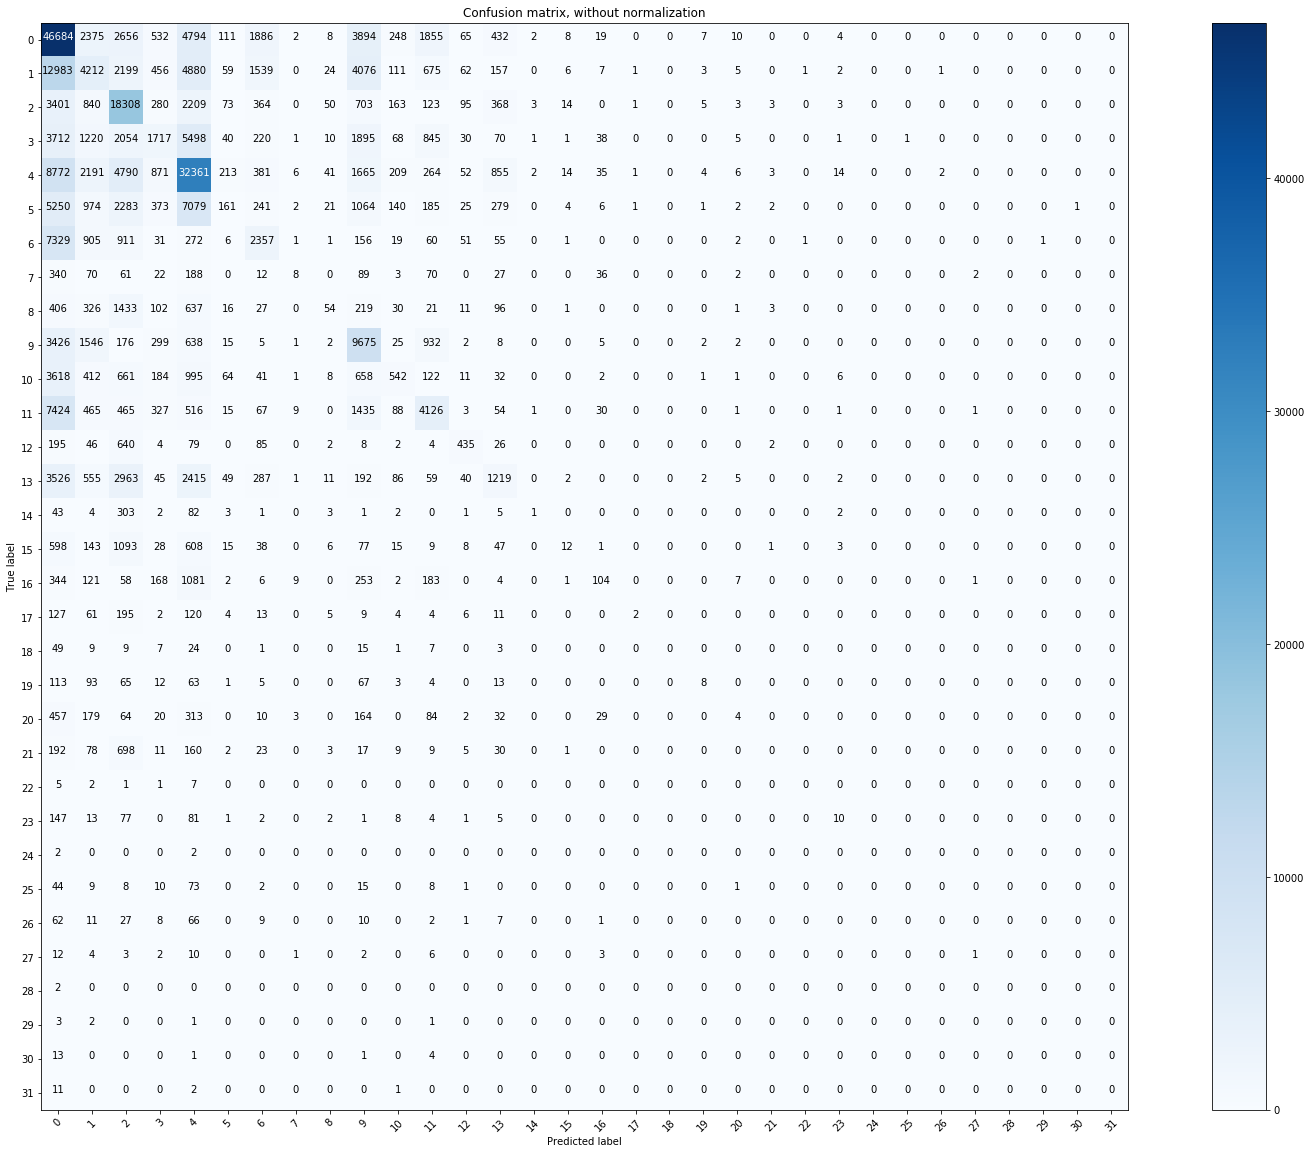

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()


# Compute confusion matrix
confusion =confusion_matrix(y_test, pred)   # Now it's just logistic regression. Will implement into other models later
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(30,20))
plot_confusion_matrix(confusion, classes=range(0,32),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(confusion, classes=range(0,32), normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [138]:
#Counter(df.Arrest)

Counter({True: 371057, False: 1047308})

In [51]:
#Counter(df.Domestic)

Counter({True: 215134, False: 1203231})

In [28]:
#df.groupby(['Primary Type','Arrest']).count()['ID']

#### Find the result on test set

In [50]:
xgb = XGBClassifier(max_depth = 10, learning_rate = 0.1, n_estimators = 300, gamma = 0, min_child_weight = 1, subsample = 1, colsample_bytree = 1,objective='multi:softmax')

In [55]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [56]:
pred = xgb.predict(X_test)

/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [65]:
y_test.nunique()

32

In [76]:
from sklearn.metrics import f1_score
f1_score(y_test, pred, average='micro')

0.41924165990845486

In [81]:
Counter(y_test)

Counter({10: 16759,
         1: 65592,
         6: 18094,
         4: 17427,
         2: 31459,
         5: 52752,
         16: 2702,
         3: 27009,
         7: 12159,
         12: 15028,
         17: 2344,
         20: 447,
         14: 11459,
         9: 3383,
         21: 1361,
         11: 7359,
         8: 930,
         13: 1528,
         22: 1238,
         27: 204,
         15: 453,
         18: 563,
         24: 352,
         19: 125,
         30: 7,
         26: 171,
         28: 44,
         23: 16,
         31: 19,
         32: 14,
         25: 4,
         29: 2})